In [1]:
! pip install -q flwr[simulation] flwr-datasets[vision] torch torchvision matplotlib
! pip install -U ipywidgets
! pip install numpy==1.26.4
! pip install urllib3==1.26.6

In [2]:
from collections import OrderedDict
from typing import Dict, List, Optional, Tuple, Union, Callable


import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import copy
import torch.nn.functional as F
import torchvision.transforms as transforms
from datasets.utils.logging import disable_progress_bar
from torch.utils.data import DataLoader
from flwr.server.strategy import Strategy
import flwr
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import Metrics, Context, Status, GetParametersRes, Parameters, GetParametersIns, MetricsAggregationFn,NDArrays,Scalar
from flwr.server import ServerApp, ServerConfig, ServerAppComponents 
from flwr.server.strategy import FedAvg, FedProx
from flwr.simulation import run_simulation
from flwr_datasets import FederatedDataset
from flwr.common import (
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    Parameters,
    Scalar,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy
from flwr.server.strategy.aggregate import aggregate, weighted_loss_avg

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Training on {DEVICE}")
print(f"Flower {flwr.__version__} / PyTorch {torch.__version__}")
disable_progress_bar()

Training on cpu
Flower 1.15.2 / PyTorch 2.6.0


In [3]:

BATCH_SIZE = 32
from flwr_datasets.partitioner import DirichletPartitioner

def load_datasets(partition_id, num_partitions: int):
    drichlet_partitioner = DirichletPartitioner(num_partitions=num_partitions, alpha=0.1, partition_by="label")
    fds = FederatedDataset(dataset="cifar10", partitioners={"train": drichlet_partitioner})
    partition = fds.load_partition(partition_id)
    # Divide data on each node: 80% train, 20% test
    partition_train_test = partition.train_test_split(test_size=0.2, seed=42)
    pytorch_transforms = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )

    def apply_transforms(batch):
        # Instead of passing transforms to CIFAR10(..., transform=transform)
        # we will use this function to dataset.with_transform(apply_transforms)
        # The transforms object is exactly the same
        batch["img"] = [pytorch_transforms(img) for img in batch["img"]]
        return batch

    partition_train_test = partition_train_test.with_transform(apply_transforms)
    trainloader = DataLoader(partition_train_test["train"], batch_size=32, shuffle=True)
    valloader = DataLoader(partition_train_test["test"], batch_size=32)
    testset = fds.load_split("test").with_transform(apply_transforms)
    testloader = DataLoader(testset, batch_size=32)
    return trainloader, valloader, testloader

In [4]:
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]


def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)


def train(net, trainloader, epochs: int):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for batch in trainloader:
            images, labels = batch["img"], batch["label"]
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(net(images), labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")
        
def proxima_train(net, trainloader, epochs: int, proximal_mu:float, global_params:List[torch.Tensor]):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for batch in trainloader:
            images, labels = batch["img"], batch["label"]
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)

            proximal_term = 0.0
            for local_weights, global_weights in zip(net.parameters(), global_params):
                proximal_term += (local_weights - global_weights).norm(2)
            loss = criterion(net(images), labels) + (proximal_mu / 2) * proximal_term


            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


def train_moon(net,train_loader, global_net,previous_net, epochs, mu, temperature):
    """Training function for MOON."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())

    previous_net.eval()
    for param in previous_net.parameters():
        param.requires_grad = False

    cnt = 0
    cos = torch.nn.CosineSimilarity(dim=-1)

    for epoch in range(epochs):
        epoch_loss_collector = []
        epoch_loss1_collector = []
        epoch_loss2_collector = []
        for _, (x, target) in enumerate(train_loader):
            x, target = x, target
            optimizer.zero_grad()
            x.requires_grad = False
            target.requires_grad = False
            target = target.long()

            # pro1 is the representation by the current model (Line 14 of Algorithm 1)
            _, pro1, out = net(x)
            # pro2 is the representation by the global model (Line 15 of Algorithm 1)
            _, pro2, _ = global_net(x)
            # posi is the positive pair
            posi = cos(pro1, pro2)
            logits = posi.reshape(-1, 1)

            # pro 3 is the representation by the previous model (Line 16 of Algorithm 1)
            _, pro3, _ = previous_net(x)
            # nega is the negative pair
            nega = cos(pro1, pro3)
            logits = torch.cat((logits, nega.reshape(-1, 1)), dim=1)

            previous_net.to("cpu")
            logits /= temperature
            labels = torch.zeros(x.size(0)).cuda().long()
            # compute the model-contrastive loss (Line 17 of Algorithm 1)
            loss2 = mu * criterion(logits, labels)
            # compute the cross-entropy loss (Line 13 of Algorithm 1)
            loss1 = criterion(out, target)
            # compute the loss (Line 18 of Algorithm 1)
            loss = loss1 + loss2

            loss.backward()
            optimizer.step()

            cnt += 1
            epoch_loss_collector.append(loss.item())
            epoch_loss1_collector.append(loss1.item())
            epoch_loss2_collector.append(loss2.item())

        epoch_loss = sum(epoch_loss_collector) / len(epoch_loss_collector)
        epoch_loss1 = sum(epoch_loss1_collector) / len(epoch_loss1_collector)
        epoch_loss2 = sum(epoch_loss2_collector) / len(epoch_loss2_collector)
        print(
            "Epoch: %d Loss: %f Loss1: %f Loss2: %f"
            % (epoch, epoch_loss, epoch_loss1, epoch_loss2)
        )






def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch["img"], batch["label"]
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

def freeze_layers(model: torch.nn.Module, trainable_layers: int) -> None:
        """Freeze specified layers of the model."""
        for idx, (name, param) in enumerate(model.named_parameters()):
            if idx == trainable_layers or trainable_layers == -1:
                param.requires_grad = True
            else:
                param.requires_grad = False

In [5]:

NETWORK_LEN = len(Net().state_dict().keys())
EPOCHS = 2
NUM_PARTITIONS = 3
NUM_OF_CYCLES  = 1
NUM_OF_FULL_UPDATES_BETWEEN_CYCLES = 5
NUM_OF_ROUNDS = (NUM_OF_CYCLES * NUM_OF_FULL_UPDATES_BETWEEN_CYCLES) + (NUM_OF_CYCLES * NETWORK_LEN *2)
print(f"Number of rounds: {NUM_OF_ROUNDS}")
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}


Number of rounds: 25


In [6]:
from flwr.common import NDArrays, Scalar

def get_evaluate_fn(
    testloader: DataLoader,
    net: torch.nn.Module,
) -> Callable[[int, NDArrays, Dict[str, Scalar]], Optional[Tuple[float, Dict[str, Scalar]]]]:
    """Return an evaluation function for server-side evaluation."""

    def evaluate(
        server_round: int, parameters: NDArrays, config: Dict[str, Scalar]
    ) -> Optional[Tuple[float, Dict[str, Scalar]]]:
        """Use the entire test set for evaluation."""
        
        # Copy model parameters to avoid modifying the original
        net_copy = copy.deepcopy(net)
        
        # Update model with the latest parameters
        params_dict = zip(net_copy.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
        net_copy.load_state_dict(state_dict, strict=True)
        
        net_copy.to(DEVICE)
        net_copy.eval()

        # Test the model
        loss, accuracy = test(net_copy, testloader)
        
        # Return loss and metrics
        return loss, {"accuracy": accuracy}

    return evaluate

# Normal FedAvg

In [7]:
from typing import Union
import sys

from flwr.common import (
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    Parameters,
    Scalar,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy
from flwr.server.strategy.aggregate import aggregate, weighted_loss_avg

def get_parameters_size(params: Parameters) -> int:
    size = sys.getsizeof(params)  # Base size of the dataclass instance
    size += sys.getsizeof(params.tensor_type)  # Size of the string
    size += sys.getsizeof(params.tensors)  # Size of the list container
    size += sum(sys.getsizeof(tensor) for tensor in params.tensors)  # Size of each bytes object
    return size

fed_avg_result = {}
fed_avg_model_results = {}

class ModifiedFedAvg(Strategy):
    def __init__(
        self,
        fraction_fit: float = 1.0,
        fraction_evaluate: float = 1.0,
        min_fit_clients: int = 2,
        min_evaluate_clients: int = 2,
        min_available_clients: int = 2,
        evaluate_fn: Optional[
            Callable[
                [int, NDArrays, dict[str, Scalar]],
                Optional[tuple[float, dict[str, Scalar]]],
            ]
        ] = None,
        on_fit_config_fn: Optional[Callable[[int], dict[str, Scalar]]] = None,
        on_evaluate_config_fn: Optional[Callable[[int], dict[str, Scalar]]] = None,
        accept_failures: bool = True,
        initial_parameters: Optional[Parameters] = None,
        fit_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        evaluate_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        inplace: bool = True,
        layer_update_strategy: str = "sequential",
        
    ) -> None:
        super().__init__()
        self.fraction_fit = fraction_fit
        self.fraction_evaluate = fraction_evaluate
        self.min_fit_clients = min_fit_clients
        self.min_evaluate_clients = min_evaluate_clients
        self.min_available_clients = min_available_clients
        self.evaluate_fn = evaluate_fn
        self.on_fit_config_fn = on_fit_config_fn
        self.on_evaluate_config_fn = on_evaluate_config_fn
        self.accept_failures = accept_failures
        self.initial_parameters = initial_parameters
        self.fit_metrics_aggregation_fn = fit_metrics_aggregation_fn
        self.evaluate_metrics_aggregation_fn = evaluate_metrics_aggregation_fn
        self.inplace = inplace


    def __repr__(self) -> str:
        return "FedPartAvg"
    

    def num_fit_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Return sample size and required number of clients."""
        num_clients = int(num_available_clients * self.fraction_fit)
        return max(num_clients, self.min_fit_clients), self.min_available_clients

    def num_evaluation_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Use a fraction of available clients for evaluation."""
        num_clients = int(num_available_clients * self.fraction_evaluate)
        return max(num_clients, self.min_evaluate_clients), self.min_available_clients
    
   
    def initialize_parameters(
        self, client_manager: ClientManager
    ) -> Optional[Parameters]:
        """Initialize global model parameters."""
        net = Net()
        ndarrays = get_parameters(net)
        return ndarrays_to_parameters(ndarrays)
    


    def evaluate(
        self, server_round: int, parameters: Parameters
    ) -> Optional[tuple[float, dict[str, Scalar]]]:
        """Evaluate model parameters using an evaluation function."""
        if self.evaluate_fn is None:
            # No evaluation function provided
            return None
        parameters_ndarrays = parameters_to_ndarrays(parameters)
        eval_res = self.evaluate_fn(server_round, parameters_ndarrays, {})
        if eval_res is None:
            return None
        loss, metrics = eval_res

        if server_round in fed_avg_model_results:
            expand_fed_avg_result= {**fed_avg_model_results[server_round], "global_loss": loss, "global_metrics": metrics}
        else:
            expand_fed_avg_result= {"global_loss": loss, "global_metrics": metrics}

        fed_avg_model_results[server_round] = expand_fed_avg_result

        return loss, metrics

    def configure_fit(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, FitIns]]:
        """Configure the next round of training."""
        
        config = {}
        
        sample_size, min_num_clients = self.num_fit_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )
        
        fit_configurations = []
        for idx, client in enumerate(clients):
            fit_configurations.append((client, FitIns(parameters, config)))

        
        return fit_configurations
    

    def configure_evaluate(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, EvaluateIns]]:
        """Configure the next round of evaluation."""
        if self.fraction_evaluate == 0.0:
            return []
        config = {}
        evaluate_ins = EvaluateIns(parameters, config)

        # Sample clients
        sample_size, min_num_clients = self.num_evaluation_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )

        # Return client/config pairs
        return [(client, evaluate_ins) for client in clients]

    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""

        # get size of parameters in bytes
        total_size = 0
        for client, fit_res in results:
            total_size += get_parameters_size(fit_res.parameters)
        

        if server_round in fed_avg_result:
            expand_fed_avg_result= {**fed_avg_result[server_round], "total_size": total_size}
        else:
            expand_fed_avg_result= {"total_size": total_size}

        fed_avg_result[server_round] = expand_fed_avg_result


        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]
        parameters_aggregated = ndarrays_to_parameters(aggregate(weights_results))
        metrics_aggregated = {}
        return parameters_aggregated, metrics_aggregated

    

    def aggregate_evaluate(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, EvaluateRes]],
        failures: List[Union[Tuple[ClientProxy, EvaluateRes], BaseException]],
    ) -> Tuple[Optional[float], Dict[str, Scalar]]:
        """Aggregate evaluation losses using weighted average."""

        if not results:
            return None, {}

        total_loss = 0
        for _, evaluate_res in results:
            total_loss += evaluate_res.loss 


        if server_round in fed_avg_result:
            expand_fed_avg_result= {**fed_avg_result[server_round], "total_loss": total_loss}
        else:
            expand_fed_avg_result= {"total_loss": total_loss}

        fed_avg_result[server_round] = expand_fed_avg_result

        loss_aggregated = weighted_loss_avg(
            [
                (evaluate_res.num_examples, evaluate_res.loss)
                for _, evaluate_res in results
            ]
        )
        metrics_aggregated = {}
        return loss_aggregated, metrics_aggregated

In [8]:
class NormalFlowerClient(NumPyClient):
    def __init__(self, partition_id, net, trainloader, valloader):
        self.partition_id = partition_id
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        print(f"[Client {self.partition_id}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        print(f"[Client {self.partition_id}] fit, config: {config}")
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=EPOCHS)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        print(f"[Client {self.partition_id}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}



def client_fn(context: Context) -> Client:
    net = Net().to(DEVICE)
    partition_id = context.node_config["partition-id"]
    num_partitions = context.node_config["num-partitions"]
    trainloader, valloader, _ = load_datasets(partition_id, num_partitions)
    return NormalFlowerClient(partition_id, net, trainloader, valloader).to_client()


# Create the ClientApp
client = ClientApp(client_fn=client_fn)

In [9]:
net = Net().to(DEVICE)

_, _, testloader = load_datasets(0, NUM_PARTITIONS)

evaluate_fn = get_evaluate_fn(testloader, net)


def server_fn(context: Context) -> ServerAppComponents:
    # Configure the server for just 3 rounds of training
    config = ServerConfig(num_rounds=NUM_OF_ROUNDS)
    return ServerAppComponents(
        config=config,
        strategy=ModifiedFedAvg(
            evaluate_fn=evaluate_fn
        ),
    )

server = ServerApp(server_fn=server_fn)

# Run simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,
    backend_config=backend_config,
)

/Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]
INFO :      Starting Flower ServerApp, config: num_rounds=25, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      initial parameters (loss, other metrics): 0.07218686480522156, {'accuracy': 0.1003}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=23133) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=23133)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=23134) [Client 1] fit, config: {}
(ClientAppActor pid=23134) Epoch 1: train loss 0.025486741214990616, accuracy 0.7143712574850299
(ClientAppActor pid=23135) [Client 0] fit, config: {} [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(ClientAppActor pid=23133) Epoch 2: train loss 0.02257741428911686, accuracy 0.7185198176078569 [repeated 3x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=23135) Epoch 2: train loss 0.03722265362739563, accuracy 0.5579485307537871 [repeated 2x across cluster]


INFO :      fit progress: (1, 0.0637495791196823, {'accuracy': 0.3583}, 27.700113916012924)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=23133) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 3x across cluster]
(ClientAppActor pid=23133)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 3x across cluster]


(ClientAppActor pid=23133) [Client 1] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=23134) [Client 1] fit, config: {}
(ClientAppActor pid=23134) Epoch 1: train loss 0.018051180988550186, accuracy 0.8244011976047905
(ClientAppActor pid=23135) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=23133) [Client 2] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=23135) Epoch 1: train loss 0.03631674125790596, accuracy 0.574374885928089 [repeated 3x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=23135) Epoch 2: train loss 0.032358378171920776, accuracy 0.6241102390947253 [repeated 2x across cluster]


INFO :      fit progress: (2, 0.06083502237796783, {'accuracy': 0.4199}, 52.19905487500364)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=23135) [Client 0] evaluate, config: {}


(ClientAppActor pid=23135) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=23135)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=23134) [Client 1] fit, config: {}
(ClientAppActor pid=23134) Epoch 1: train loss 0.015678171068429947, accuracy 0.8458083832335329
(ClientAppActor pid=23133) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=23133) [Client 2] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=23135) Epoch 1: train loss 0.03210457041859627, accuracy 0.6269848512502282 [repeated 3x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=23135) Epoch 2: train loss 0.029380997642874718, accuracy 0.6640810366855265 [repeated 2x across cluster]


INFO :      fit progress: (3, 0.0612017126083374, {'accuracy': 0.4613}, 75.94492708297912)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=23134) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=23134)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=23134) [Client 2] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=23133) [Client 2] fit, config: {}
(ClientAppActor pid=23134) Epoch 1: train loss 0.01457163318991661, accuracy 0.8531437125748503
(ClientAppActor pid=23135) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=23135) [Client 0] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=23133) Epoch 2: train loss 0.016109075397253036, accuracy 0.8100666432830586 [repeated 3x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=23135) Epoch 2: train loss 0.02664876915514469, accuracy 0.6979832086147107 [repeated 2x across cluster]


INFO :      fit progress: (4, 0.058513656467199325, {'accuracy': 0.4976}, 100.45144787500612)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=23135) [Client 0] evaluate, config: {}


(ClientAppActor pid=23135) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=23135)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=23134) [Client 1] fit, config: {}
(ClientAppActor pid=23134) Epoch 1: train loss 0.01328344363719225, accuracy 0.8661676646706586
(ClientAppActor pid=23134) [Client 2] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=23135) [Client 0] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=23135) Epoch 1: train loss 0.026445230469107628, accuracy 0.695199853987954 [repeated 3x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=23135) Epoch 2: train loss 0.02430924028158188, accuracy 0.7264555575835007 [repeated 2x across cluster]


INFO :      fit progress: (5, 0.059175993227958676, {'accuracy': 0.5199}, 123.75593291601399)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=23134) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=23134)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=23134) [Client 2] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=23135) [Client 0] fit, config: {}
(ClientAppActor pid=23134) Epoch 1: train loss 0.012981035746634007, accuracy 0.8709580838323353
(ClientAppActor pid=23133) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=23134) [Client 1] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=23135) Epoch 1: train loss 0.024245765060186386, accuracy 0.7283263369227961 [repeated 3x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=23135) Epoch 2: train loss 0.02220086008310318, accuracy 0.7499543712356269 [repeated 2x across cluster]


INFO :      fit progress: (6, 0.05942026572823524, {'accuracy': 0.5293}, 146.81954883300932)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=23135) [Client 0] evaluate, config: {}


(ClientAppActor pid=23135) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=23135)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=23134) [Client 1] fit, config: {}
(ClientAppActor pid=23134) Epoch 1: train loss 0.012294834479689598, accuracy 0.8766467065868263
(ClientAppActor pid=23133) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=23133) [Client 2] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=23135) Epoch 1: train loss 0.02218620665371418, accuracy 0.7511863478736995 [repeated 3x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=23135) Epoch 2: train loss 0.020452652126550674, accuracy 0.7724949808359189 [repeated 2x across cluster]


INFO :      fit progress: (7, 0.055894663083553314, {'accuracy': 0.5504}, 172.1791956659872)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=23133) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=23133)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=23133) [Client 1] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=23133) [Client 2] fit, config: {}
(ClientAppActor pid=23134) Epoch 1: train loss 0.012143938802182674, accuracy 0.8766467065868263
(ClientAppActor pid=23135) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=23134) [Client 1] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=23135) Epoch 1: train loss 0.020439516752958298, accuracy 0.7683427632779705 [repeated 3x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=23135) Epoch 2: train loss 0.018633201718330383, accuracy 0.7932560686256617 [repeated 2x across cluster]


INFO :      fit progress: (8, 0.05691051480174065, {'accuracy': 0.5584}, 195.73992241598899)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=23133) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=23133)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=23133) [Client 1] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=23133) [Client 2] fit, config: {}
(ClientAppActor pid=23135) Epoch 1: train loss 0.011564155109226704, accuracy 0.8818862275449102
(ClientAppActor pid=23134) [Client 2] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=23135) [Client 1] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=23134) Epoch 1: train loss 0.018854770809412003, accuracy 0.7907464865851432 [repeated 3x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=23134) Epoch 2: train loss 0.017075300216674805, accuracy 0.8079941595181602 [repeated 2x across cluster]


INFO :      fit progress: (9, 0.05688445844650269, {'accuracy': 0.5433}, 219.01137487503001)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=23133) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=23133)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=23133) [Client 1] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=23133) [Client 2] fit, config: {}
(ClientAppActor pid=23133) Epoch 1: train loss 0.015141609124839306, accuracy 0.8275166608207647
(ClientAppActor pid=23134) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=23133) Epoch 2: train loss 0.011406879872083664, accuracy 0.86741494212557


(ClientAppActor pid=23134) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 4x across cluster]
(ClientAppActor pid=23134)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 4x across cluster]


(ClientAppActor pid=23134) [Client 0] fit, config: {}
(ClientAppActor pid=23134) Epoch 1: train loss 0.017569847404956818, accuracy 0.80411571454645


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=23135, ip=127.0.0.1, actor_id=dfff663d49823be91aa5f80501000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x108c3ab40>)
  File "/Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/requests/models.py", line 1024, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 504 Server Error: Gateway Time-out for url: https://huggingface.co/api/datasets/uoft-cs/cifar10/paths-info/0b2714987fa478483af9968de7c934580d0bb9a2

The above exception was the direct cause of the following exception:

ray::ClientAppActor.run() (pid=23135, ip=127.0.0.1, actor_id=dfff663d49823be91aa5f80501000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x108c3ab40>)
  File "/Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/flwr/simulation/ray_transport

(ClientAppActor pid=23134) Epoch 2: train loss 0.01572311855852604, accuracy 0.823553568169374


INFO :      fit progress: (10, 0.06525311844348908, {'accuracy': 0.5223}, 251.8445901250234)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=23133) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=23133)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=23134) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=23134)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=23133) [Client 2] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=23135) [Client 0] fit, config: {}
(ClientAppActor pid=23134) Epoch 1: train loss 0.013020915910601616, accuracy 0.8755988023952096
(ClientAppActor pid=23135) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=23133) [Client 2] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=23135) Epoch 1: train loss 0.01555731613188982, accuracy 0.8244661434568352 [repeated 3x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=23135) Epoch 2: train loss 0.013882131315767765, accuracy 0.8456835188903085 [repeated 2x across cluster]


INFO :      fit progress: (11, 0.061272642576694486, {'accuracy': 0.5582}, 274.71124737500213)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=23134) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=23134)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]


(ClientAppActor pid=23134) [Client 2] evaluate, config: {}


(ClientAppActor pid=23133) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=23133) Found the latest cached dataset configuration 'plain_text' at /Users/macbook/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Sun Feb 23 20:40:10 2025).
(ClientAppActor pid=23133) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=23133)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=23133) [Client 1] evaluate, config: {}
(ClientAppActor pid=23135) [Client 0] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=23133) [Client 1] fit, config: {}
(ClientAppActor pid=23133) Epoch 1: train loss 0.011838601902127266, accuracy 0.8811377245508982
(ClientAppActor pid=23133) Epoch 2: train loss 0.008462377823889256, accuracy 0.9100299401197605


(ClientAppActor pid=23134) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=23134) Found the latest cached dataset configuration 'plain_text' at /Users/macbook/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Sun Feb 23 20:40:10 2025).
(ClientAppActor pid=23133) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 2x across cluster]
(ClientAppActor pid=23133)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 2x across cluster]


(ClientAppActor pid=23134) [Client 2] fit, config: {}
(ClientAppActor pid=23135) [Client 0] fit, config: {}
(ClientAppActor pid=23134) Epoch 1: train loss 0.014099338091909885, accuracy 0.8419852683269028
(ClientAppActor pid=23134) Epoch 2: train loss 0.01035910751670599, accuracy 0.8792528937215013


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=23135) Epoch 2: train loss 0.012858645990490913, accuracy 0.8563150209892316 [repeated 2x across cluster]


INFO :      fit progress: (12, 0.06321742297410965, {'accuracy': 0.5465}, 317.8758046660223)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=23134) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 3x across cluster]
(ClientAppActor pid=23134)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 3x across cluster]


(ClientAppActor pid=23134) [Client 1] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=23134) [Client 2] fit, config: {}
(ClientAppActor pid=23133) Epoch 1: train loss 0.01123499684035778, accuracy 0.8872754491017965
(ClientAppActor pid=23135) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=23133) [Client 1] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=23135) Epoch 1: train loss 0.01323011890053749, accuracy 0.8527103486037598 [repeated 3x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=23135) Epoch 2: train loss 0.011374328285455704, accuracy 0.8707793392954919 [repeated 2x across cluster]


INFO :      fit progress: (13, 0.06342586410641671, {'accuracy': 0.5417}, 341.1719838330173)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=23133) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=23133)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=23134) [Client 1] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=23134) [Client 2] fit, config: {}
(ClientAppActor pid=23133) Epoch 1: train loss 0.011110262013971806, accuracy 0.8887724550898204
(ClientAppActor pid=23135) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=23135) [Client 0] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=23135) Epoch 1: train loss 0.011773867532610893, accuracy 0.8672659244387662 [repeated 3x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=23135) Epoch 2: train loss 0.01023287046700716, accuracy 0.8870231794123015 [repeated 2x across cluster]


INFO :      fit progress: (14, 0.06584741241931916, {'accuracy': 0.5405}, 364.2379337500315)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=23135) [Client 0] evaluate, config: {}


(ClientAppActor pid=23135) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=23135)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=23134) [Client 1] fit, config: {}
(ClientAppActor pid=23134) Epoch 1: train loss 0.01155374851077795, accuracy 0.8817365269461078
(ClientAppActor pid=23134) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=23133) [Client 2] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=23135) Epoch 1: train loss 0.010863121598958969, accuracy 0.876893593721482 [repeated 3x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=23135) Epoch 2: train loss 0.009237442165613174, accuracy 0.8977003102755977 [repeated 2x across cluster]


INFO :      fit progress: (15, 0.06702712287306786, {'accuracy': 0.5343}, 386.85142333299154)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=23134) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=23134)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=23134) [Client 2] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=23133) [Client 2] fit, config: {}
(ClientAppActor pid=23134) Epoch 1: train loss 0.011405935510993004, accuracy 0.8851796407185629
(ClientAppActor pid=23135) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=23134) [Client 1] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=23135) Epoch 1: train loss 0.00961437076330185, accuracy 0.8921792297864574 [repeated 3x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=23135) Epoch 2: train loss 0.008518621325492859, accuracy 0.903130133235992 [repeated 2x across cluster]


INFO :      fit progress: (16, 0.0701347048163414, {'accuracy': 0.5302}, 409.8950930830324)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=23134) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=23134)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=23134) [Client 2] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=23135) [Client 0] fit, config: {}
(ClientAppActor pid=23134) Epoch 1: train loss 0.011003871448338032, accuracy 0.8818862275449102
(ClientAppActor pid=23133) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=23133) [Client 2] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=23135) Epoch 1: train loss 0.008829385042190552, accuracy 0.9019437853622924 [repeated 3x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=23135) Epoch 2: train loss 0.007536496035754681, accuracy 0.9137616353349152 [repeated 2x across cluster]


INFO :      fit progress: (17, 0.07373570038676262, {'accuracy': 0.5383}, 432.5940247499966)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=23134) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=23134)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=23134) [Client 2] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=23134) [Client 1] fit, config: {}
(ClientAppActor pid=23134) Epoch 1: train loss 0.011262809857726097, accuracy 0.8857784431137724
(ClientAppActor pid=23135) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=23135) [Client 0] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=23135) Epoch 1: train loss 0.007867067120969296, accuracy 0.9105676218288009 [repeated 3x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=23135) Epoch 2: train loss 0.007014025934040546, accuracy 0.9207428362839934 [repeated 2x across cluster]


INFO :      fit progress: (18, 0.07683725988268852, {'accuracy': 0.5361}, 454.90565116598736)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=23133) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=23133)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=23134) [Client 2] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=23135) [Client 0] fit, config: {}
(ClientAppActor pid=23134) Epoch 1: train loss 0.0110836923122406, accuracy 0.8896706586826347
(ClientAppActor pid=23135) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=23134) [Client 1] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=23135) Epoch 1: train loss 0.00739822955802083, accuracy 0.9138072640992881 [repeated 3x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=23135) Epoch 2: train loss 0.006131617818027735, accuracy 0.9310549370323051 [repeated 2x across cluster]


INFO :      fit progress: (19, 0.0764628250181675, {'accuracy': 0.5321}, 476.83559570799116)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=23133) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=23133)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=23134) [Client 2] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=23134) [Client 1] fit, config: {}
(ClientAppActor pid=23134) Epoch 1: train loss 0.011062240228056908, accuracy 0.8895209580838324
(ClientAppActor pid=23135) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=23135) [Client 0] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=23135) Epoch 1: train loss 0.00661054439842701, accuracy 0.9249863113706881 [repeated 3x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=23135) Epoch 2: train loss 0.006107605993747711, accuracy 0.930918050739186 [repeated 2x across cluster]


INFO :      fit progress: (20, 0.08823428449034691, {'accuracy': 0.5352}, 498.9204978750204)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=23135) [Client 0] evaluate, config: {}


(ClientAppActor pid=23135) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=23135)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=23133) [Client 2] fit, config: {}
(ClientAppActor pid=23134) Epoch 1: train loss 0.011119299568235874, accuracy 0.8899700598802395
(ClientAppActor pid=23133) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=23135) [Client 0] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=23135) Epoch 1: train loss 0.006263536401093006, accuracy 0.9310549370323051 [repeated 3x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=23135) Epoch 2: train loss 0.005252262111753225, accuracy 0.9403175762000365 [repeated 2x across cluster]


INFO :      fit progress: (21, 0.08302535197734832, {'accuracy': 0.5289}, 521.0212833330152)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=23133) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=23133)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=23133) [Client 1] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=23134) [Client 1] fit, config: {}
(ClientAppActor pid=23134) Epoch 1: train loss 0.011507948860526085, accuracy 0.8854790419161677
(ClientAppActor pid=23134) [Client 2] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=23133) [Client 2] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=23135) Epoch 1: train loss 0.0057404739782214165, accuracy 0.9364847599926994 [repeated 3x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=23135) Epoch 2: train loss 0.005075774155557156, accuracy 0.9420058404818398 [repeated 2x across cluster]


INFO :      fit progress: (22, 0.09093479740619659, {'accuracy': 0.5378}, 543.3355854160036)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=23133) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=23133)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=23133) [Client 1] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=23134) [Client 1] fit, config: {}
(ClientAppActor pid=23134) Epoch 1: train loss 0.011530423536896706, accuracy 0.8808383233532934
(ClientAppActor pid=23135) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=23135) [Client 0] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=23135) Epoch 1: train loss 0.005354683380573988, accuracy 0.9392224858550831 [repeated 3x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=23135) Epoch 2: train loss 0.004633661825209856, accuracy 0.9488045263734258 [repeated 2x across cluster]


INFO :      fit progress: (23, 0.09302216400206088, {'accuracy': 0.5296}, 566.1279441660154)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=23133) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=23133)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=23133) [Client 1] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=23134) [Client 1] fit, config: {}
(ClientAppActor pid=23134) Epoch 1: train loss 0.010968788526952267, accuracy 0.8908682634730539
(ClientAppActor pid=23135) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=23135) [Client 0] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=23135) Epoch 1: train loss 0.005099948961287737, accuracy 0.9407282350793941 [repeated 3x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=23135) Epoch 2: train loss 0.004263442009687424, accuracy 0.9513141084139441 [repeated 2x across cluster]


INFO :      fit progress: (24, 0.09696684302687646, {'accuracy': 0.5296}, 589.6968988330336)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=23134) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=23134)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=23134) [Client 2] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=23134) [Client 2] fit, config: {}
(ClientAppActor pid=23133) Epoch 1: train loss 0.011024084873497486, accuracy 0.8931137724550898
(ClientAppActor pid=23133) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=23135) [Client 0] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=23135) Epoch 1: train loss 0.004761745687574148, accuracy 0.9469337470341304 [repeated 3x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=23135) Epoch 2: train loss 0.004249246791005135, accuracy 0.9514509947070633 [repeated 2x across cluster]


INFO :      fit progress: (25, 0.09899823991656304, {'accuracy': 0.5268}, 615.1204249580042)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=23134) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=23134)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=23134) [Client 1] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 25 round(s) in 618.55s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.06427737038610418
INFO :      		round 2: 0.061249095958972474
INFO :      		round 3: 0.061385952582655334
INFO :      		round 4: 0.058527664436196045
INFO :      		round 5: 0.05870683093929561
INFO :      		round 6: 0.05866232042269012
INFO :      		round 7: 0.055183902897100796
INFO :      		round 8: 0.056197311164418125
INFO :      		round 9: 0.05601045533789482
INFO :      		round 10: 0.0642652006624976
INFO :      		round 11: 0.060122292305190776
INFO :      		round 12: 0.062091781698262266
INFO :      		round 13: 0.062109330145771
INFO :      		round 14: 0.06441567083293466
INFO :      		round 15: 0.06558967091624418
INFO :      		round 16: 0.06860548414040414
INFO :      		round 17: 0.07153344233845439
INFO :      		round 18: 0.07522892512513016
INFO :      		round 19

(ClientAppActor pid=23135) [Client 0] evaluate, config: {} [repeated 2x across cluster]


(ClientAppActor pid=23135) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 2x across cluster]
(ClientAppActor pid=23135)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 2x across cluster]


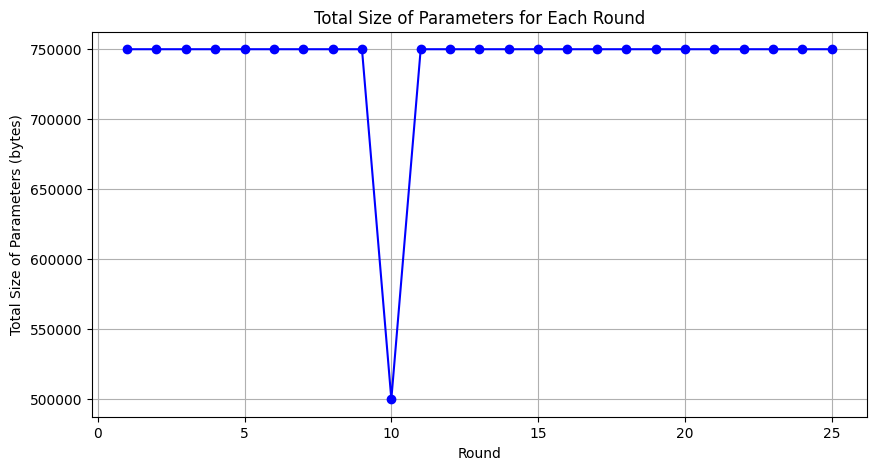

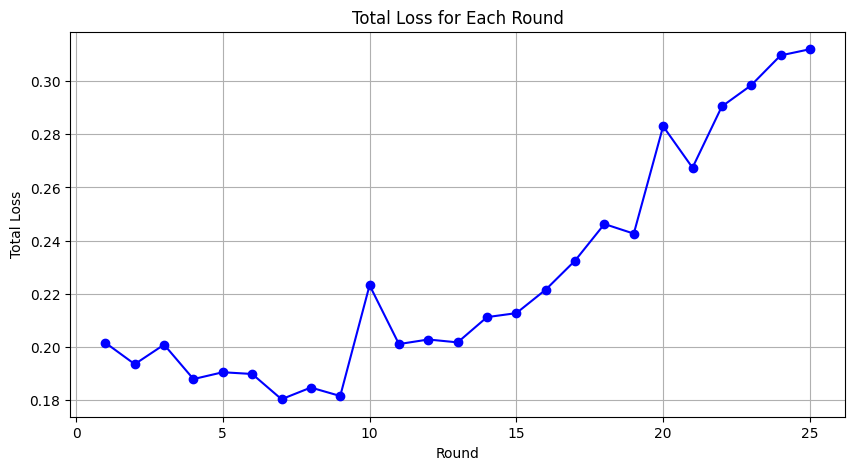

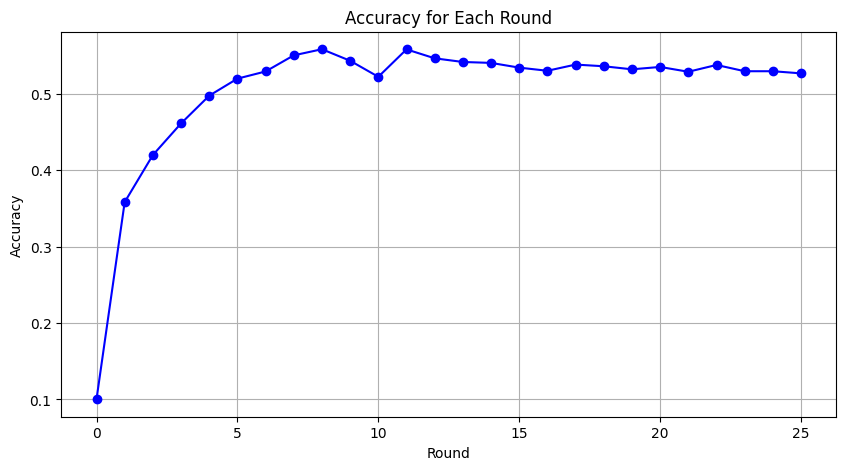

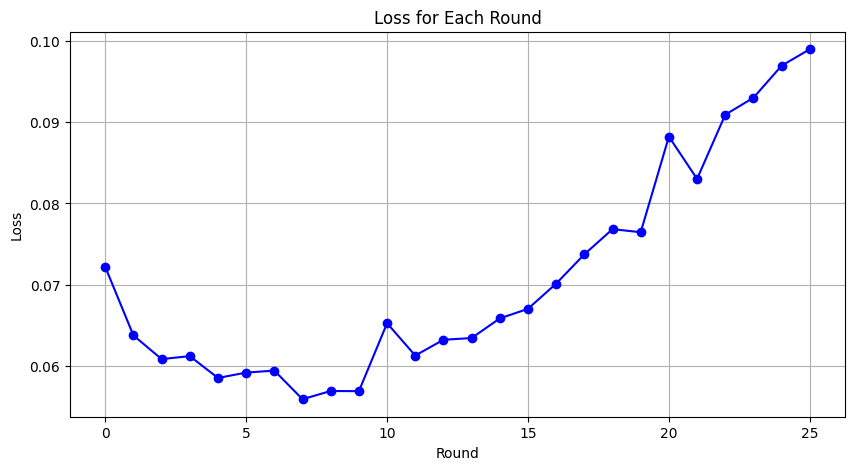

In [10]:
import matplotlib.pyplot as plt
import numpy as np


fed_avg_rounds = list(fed_avg_result.keys())
fed_avg_sizes = [fed_avg_result[round]["total_size"] for round in fed_avg_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_avg_rounds, fed_avg_sizes, marker='o', linestyle='-', color='b')
plt.xlabel('Round')
plt.ylabel('Total Size of Parameters (bytes)')
plt.title('Total Size of Parameters for Each Round')
plt.grid(True)

fed_avg_losses = [fed_avg_result[round]["total_loss"] for round in fed_avg_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_avg_rounds, fed_avg_losses, marker='o', linestyle='-', color='b')
plt.xlabel('Round')
plt.ylabel('Total Loss')
plt.title('Total Loss for Each Round')
plt.grid(True)

fed_avg_model_rounds = list(fed_avg_model_results.keys())

fed_avg_accuracies = [fed_avg_model_results[round]["global_metrics"]["accuracy"] for round in fed_avg_model_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_avg_model_rounds, fed_avg_accuracies, marker='o', linestyle='-', color='b')
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.title('Accuracy for Each Round')
plt.grid(True)

fed_avg_global_losses = [fed_avg_model_results[round]["global_loss"] for round in fed_avg_model_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_avg_model_rounds, fed_avg_global_losses, marker='o', linestyle='-', color='b')
plt.xlabel('Round')
plt.ylabel('Loss')
plt.title('Loss for Each Round')
plt.grid(True)

# FedAvgPart Experiments

In [11]:
from typing import Union

from flwr.common import (
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    Parameters,
    Scalar,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy
from flwr.server.strategy.aggregate import aggregate, weighted_loss_avg

fed_part_avg_result = {}

fed_part_avg_model_results = {}


class FedPartAvg(Strategy):
    def __init__(
        self,
        fraction_fit: float = 1.0,
        fraction_evaluate: float = 1.0,
        min_fit_clients: int = 2,
        min_evaluate_clients: int = 2,
        min_available_clients: int = 2,
        evaluate_fn: Optional[
            Callable[
                [int, NDArrays, dict[str, Scalar]],
                Optional[tuple[float, dict[str, Scalar]]],
            ]
        ] = None,
        on_fit_config_fn: Optional[Callable[[int], dict[str, Scalar]]] = None,
        on_evaluate_config_fn: Optional[Callable[[int], dict[str, Scalar]]] = None,
        accept_failures: bool = True,
        initial_parameters: Optional[Parameters] = None,
        fit_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        evaluate_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        inplace: bool = True,
        layer_update_strategy: str = "sequential",
        
    ) -> None:
        super().__init__()
        self.fraction_fit = fraction_fit
        self.fraction_evaluate = fraction_evaluate
        self.min_fit_clients = min_fit_clients
        self.min_evaluate_clients = min_evaluate_clients
        self.min_available_clients = min_available_clients
        self.evaluate_fn = evaluate_fn
        self.on_fit_config_fn = on_fit_config_fn
        self.on_evaluate_config_fn = on_evaluate_config_fn
        self.accept_failures = accept_failures
        self.initial_parameters = initial_parameters
        self.fit_metrics_aggregation_fn = fit_metrics_aggregation_fn
        self.evaluate_metrics_aggregation_fn = evaluate_metrics_aggregation_fn
        self.inplace = inplace

        self.layer_update_strategy = layer_update_strategy  # 'sequential' or 'cyclic'
        self.current_layer = 0  # Track which layer to update
        self.number_of_layers = None
        self.layer_training_sequence = []
        self.training_sequence_index = 0
        self.latest_parameters = initial_parameters


    def __repr__(self) -> str:
        return "FedPartAvg"
    

    def num_fit_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Return sample size and required number of clients."""
        num_clients = int(num_available_clients * self.fraction_fit)
        return max(num_clients, self.min_fit_clients), self.min_available_clients

    def num_evaluation_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Use a fraction of available clients for evaluation."""
        num_clients = int(num_available_clients * self.fraction_evaluate)
        return max(num_clients, self.min_evaluate_clients), self.min_available_clients
    
    def generate_layer_training_sequence(self) -> List[int]:
        """Generate a sequence of layers to train."""
        layer_training_sequence = []
        for _ in range(NUM_OF_CYCLES):
            for _ in range(NUM_OF_FULL_UPDATES_BETWEEN_CYCLES):
                    layer_training_sequence.append(-1)
            for layer in range(NETWORK_LEN):
                    layer_training_sequence.append(layer)
                    layer_training_sequence.append(layer)

        return layer_training_sequence

    def initialize_parameters(
        self, client_manager: ClientManager
    ) -> Optional[Parameters]:
        """Initialize global model parameters."""
        net = Net()
        ndarrays = get_parameters(net)
        self.layer_training_sequence = self.generate_layer_training_sequence()
        self.number_of_layers = len(ndarrays)

        return ndarrays_to_parameters(ndarrays)
    


    def evaluate(
        self, server_round: int, parameters: Parameters
    ) -> Optional[tuple[float, dict[str, Scalar]]]:
        """Evaluate model parameters using an evaluation function."""
        if self.evaluate_fn is None:
            # No evaluation function provided
            return None
        parameters_ndarrays = parameters_to_ndarrays(parameters)
        eval_res = self.evaluate_fn(server_round, parameters_ndarrays, {})
        if eval_res is None:
            return None
        
        if server_round in fed_part_avg_model_results:  
            expand_fed_part_avg_model_results= {**fed_part_avg_model_results[server_round], "global_loss": eval_res[0], "global_metrics": eval_res[1]}
        else:
            expand_fed_part_avg_model_results= {"global_loss": eval_res[0], "global_metrics": eval_res[1]}
        
        fed_part_avg_model_results[server_round] = expand_fed_part_avg_model_results
        
        loss, metrics = eval_res
        return loss, metrics

    def configure_fit(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, FitIns]]:
        """Configure the next round of training."""
        
        config = {"trainable_layers": self.layer_training_sequence[self.training_sequence_index]}
        
        sample_size, min_num_clients = self.num_fit_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )
        
        print(f"Training on layer {self.layer_training_sequence}")
        fit_configurations = []
        for idx, client in enumerate(clients):
            fit_configurations.append((client, FitIns(parameters, config)))

        self.training_sequence_index = self.training_sequence_index + 1
        
        return fit_configurations
    

    def configure_evaluate(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, EvaluateIns]]:
        """Configure the next round of evaluation."""
        if self.fraction_evaluate == 0.0:
            return []
        config = {}
        evaluate_ins = EvaluateIns(parameters, config)

        # Sample clients
        sample_size, min_num_clients = self.num_evaluation_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )

        # Return client/config pairs
        return [(client, evaluate_ins) for client in clients]

    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""
        
        total_size = 0
        for client, fit_res in results:
            total_size += get_parameters_size(fit_res.parameters)
        print(f"total size: {total_size}")
        
        if fed_part_avg_result.get(server_round):
            fed_part_avg_result[server_round]["total_size"] = total_size
        else:
            fed_part_avg_result[server_round] = {"total_size": total_size}
        


        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]

        aggregated_weights = aggregate(weights_results)
        # parameters_aggregated = ndarrays_to_parameters(aggregate(weights_results))

        if self.layer_training_sequence[self.training_sequence_index -1] == -1:
            self.latest_parameters = ndarrays_to_parameters(aggregated_weights)
        else:
            current_model = parameters_to_ndarrays(self.latest_parameters)
            current_model[self.layer_training_sequence[self.training_sequence_index -1]] = aggregated_weights[0]
            self.latest_parameters = ndarrays_to_parameters(current_model)

        metrics_aggregated = {}
        return self.latest_parameters, metrics_aggregated

    

    def aggregate_evaluate(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, EvaluateRes]],
        failures: List[Union[Tuple[ClientProxy, EvaluateRes], BaseException]],
    ) -> Tuple[Optional[float], Dict[str, Scalar]]:
        """Aggregate evaluation losses using weighted average."""

        if not results:
            return None, {}
        
        total_loss = 0
        for _, evaluate_res in results:
            total_loss += evaluate_res.loss

        if fed_part_avg_result.get(server_round):
            fed_part_avg_result[server_round]["total_loss"] = total_loss
        else:
            fed_part_avg_result[server_round] = {"total_loss": total_loss}

        loss_aggregated = weighted_loss_avg(
            [
                (evaluate_res.num_examples, evaluate_res.loss)
                for _, evaluate_res in results
            ]
        )
        metrics_aggregated = {}
        return loss_aggregated, metrics_aggregated

    

In [12]:
class FedAvgPartFlowerClient(NumPyClient):
    def __init__(self, partition_id, net, trainloader, valloader):
        self.partition_id = partition_id
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        print(f"[Client {self.partition_id}] get_parameters")
        parameters = get_parameters(self.net)
        if config["trainable_layers"] == -1:
            return parameters
        
        trained_layer = parameters[config["trainable_layers"]]
        return [trained_layer]

    def fit(self, parameters, config):
        print(f"[Client {self.partition_id}] fit, config: {config}")
        set_parameters(self.net, parameters)
        freeze_layers(self.net, config["trainable_layers"])
        train(self.net, self.trainloader, epochs=EPOCHS)
        return self.get_parameters(config), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        print(f"[Client {self.partition_id}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn(context: Context) -> Client:
    net = Net().to(DEVICE)
    partition_id = context.node_config["partition-id"]
    num_partitions = context.node_config["num-partitions"]
    trainloader, valloader, _ = load_datasets(partition_id, num_partitions)
    return FedAvgPartFlowerClient(partition_id, net, trainloader, valloader).to_client()


# Create the ClientApp
client = ClientApp(client_fn=client_fn)

In [13]:
net = Net().to(DEVICE)

_, _, testloader = load_datasets(0, NUM_PARTITIONS)

evaluate_fn = get_evaluate_fn(testloader, net)

def server_fn(context: Context) -> ServerAppComponents:
    # Configure the server for just 3 rounds of training
    config = ServerConfig(num_rounds=NUM_OF_ROUNDS)
    return ServerAppComponents(
        config=config,
        strategy=FedPartAvg(
            evaluate_fn=evaluate_fn,
        ),
    )

server = ServerApp(server_fn=server_fn)

# Run simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,
    backend_config=backend_config,
)

/Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]
INFO :      Starting Flower ServerApp, config: num_rounds=25, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      initial parameters (loss, other metrics): 0.07209469392299653, {'accuracy': 0.1055}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=35393) [Client 0] fit, config: {'trainable_layers': -1}


(ClientAppActor pid=35393) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=35393)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=35392) Epoch 1: train loss 0.024321703240275383, accuracy 0.7425149700598802
(ClientAppActor pid=35392) [Client 1] fit, config: {'trainable_layers': -1} [repeated 2x across cluster]
(ClientAppActor pid=35392) [Client 1] get_parameters
(ClientAppActor pid=35391) Epoch 2: train loss 0.02171018347144127, accuracy 0.7317607856892319 [repeated 4x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=35393) [Client 0] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=35393) Epoch 2: train loss 0.038199011236429214, accuracy 0.5401076838839204
total size: 749760


INFO :      fit progress: (1, 0.06475368040800095, {'accuracy': 0.3218}, 25.01967358397087)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=35392) [Client 2] evaluate, config: {}


(ClientAppActor pid=35392) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 3x across cluster]
(ClientAppActor pid=35392)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 3x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=35393) [Client 0] fit, config: {'trainable_layers': -1}
(ClientAppActor pid=35392) Epoch 1: train loss 0.018190758302807808, accuracy 0.8270958083832335
(ClientAppActor pid=35391) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=35392) [Client 1] get_parameters
(ClientAppActor pid=35392) [Client 1] fit, config: {'trainable_layers': -1} [repeated 2x across cluster]
(ClientAppActor pid=35393) Epoch 1: train loss 0.0374181754887104, accuracy 0.5579485307537871 [repeated 3x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 749760
(ClientAppActor pid=35393) [Client 0] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=35393) Epoch 2: train loss 0.03353403881192207, accuracy 0.6062693922248585 [repeated 2x across cluster]


INFO :      fit progress: (2, 0.06239964354038238, {'accuracy': 0.3653}, 50.21263891697163)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=35392) [Client 2] evaluate, config: {}


(ClientAppActor pid=35392) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=35392)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=35391) [Client 2] fit, config: {'trainable_layers': -1}
(ClientAppActor pid=35392) Epoch 1: train loss 0.015486128628253937, accuracy 0.8470059880239521
(ClientAppActor pid=35393) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=35392) [Client 1] get_parameters
(ClientAppActor pid=35392) [Client 1] fit, config: {'trainable_layers': -1} [repeated 2x across cluster]
(ClientAppActor pid=35393) Epoch 1: train loss 0.032986924052238464, accuracy 0.6123380178864757 [repeated 3x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 749760
(ClientAppActor pid=35393) [Client 0] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=35393) Epoch 2: train loss 0.030340716242790222, accuracy 0.6451907282350794 [repeated 2x across cluster]


INFO :      fit progress: (3, 0.05865464650392532, {'accuracy': 0.4527}, 74.73699137498625)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=35392) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=35392)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=35392) [Client 2] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=35392) [Client 1] fit, config: {'trainable_layers': -1}
(ClientAppActor pid=35392) Epoch 1: train loss 0.014512017369270325, accuracy 0.8555389221556886
(ClientAppActor pid=35391) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=35392) [Client 1] get_parameters
(ClientAppActor pid=35391) [Client 2] fit, config: {'trainable_layers': -1} [repeated 2x across cluster]
(ClientAppActor pid=35393) Epoch 1: train loss 0.03032403439283371, accuracy 0.6474721664537324 [repeated 3x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=35393) [Client 0] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=35393) Epoch 2: train loss 0.027632789686322212, accuracy 0.6813287096185435 [repeated 2x across cluster]
total size: 749760


INFO :      fit progress: (4, 0.05576166797876358, {'accuracy': 0.5005}, 97.45888579194434)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=35393) [Client 0] evaluate, config: {}


(ClientAppActor pid=35393) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=35393)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=35391) [Client 2] fit, config: {'trainable_layers': -1}
(ClientAppActor pid=35392) Epoch 1: train loss 0.013664337806403637, accuracy 0.8583832335329341
(ClientAppActor pid=35392) [Client 2] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=35392) [Client 1] get_parameters
(ClientAppActor pid=35393) [Client 0] fit, config: {'trainable_layers': -1} [repeated 2x across cluster]
(ClientAppActor pid=35391) Epoch 2: train loss 0.015431366860866547, accuracy 0.8176955454226588 [repeated 3x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 749760
(ClientAppActor pid=35393) [Client 0] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=35393) Epoch 2: train loss 0.025415636599063873, accuracy 0.7053294396787735 [repeated 2x across cluster]


INFO :      fit progress: (5, 0.056550976479053494, {'accuracy': 0.4981}, 120.77146145899314)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=35392) [Client 2] evaluate, config: {}


(ClientAppActor pid=35392) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=35392)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=35391) [Client 2] fit, config: {'trainable_layers': 0}
(ClientAppActor pid=35392) Epoch 1: train loss 0.03549550846219063, accuracy 0.6124251497005988
(ClientAppActor pid=35393) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=35392) [Client 1] get_parameters
(ClientAppActor pid=35393) [Client 0] fit, config: {'trainable_layers': 0} [repeated 2x across cluster]
(ClientAppActor pid=35393) Epoch 1: train loss 0.0309230238199234, accuracy 0.6374338382916591 [repeated 3x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=35393) [Client 0] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=35393) Epoch 2: train loss 0.029786523431539536, accuracy 0.6528563606497536 [repeated 2x across cluster]
total size: 6453


INFO :      fit progress: (6, 0.05499819673895836, {'accuracy': 0.508}, 142.7956033749506)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=35392) [Client 2] evaluate, config: {}


(ClientAppActor pid=35392) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=35392)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=35391) [Client 2] fit, config: {'trainable_layers': 0}
(ClientAppActor pid=35392) Epoch 1: train loss 0.03512053191661835, accuracy 0.6281437125748504
(ClientAppActor pid=35393) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=35392) [Client 1] get_parameters
(ClientAppActor pid=35392) [Client 1] fit, config: {'trainable_layers': 0} [repeated 2x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 6453
(ClientAppActor pid=35393) Epoch 2: train loss 0.029459793120622635, accuracy 0.6570085782077021 [repeated 5x across cluster]
(ClientAppActor pid=35393) [Client 0] get_parameters [repeated 2x across cluster]


INFO :      fit progress: (7, 0.05478019639849663, {'accuracy': 0.5092}, 163.61208395898575)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=35391) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=35391)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=35391) [Client 1] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=35393) [Client 0] fit, config: {'trainable_layers': 1}
(ClientAppActor pid=35392) Epoch 1: train loss 0.03910166025161743, accuracy 0.5663173652694611
(ClientAppActor pid=35393) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=35392) [Client 1] get_parameters
(ClientAppActor pid=35391) [Client 2] fit, config: {'trainable_layers': 1} [repeated 2x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 1125
(ClientAppActor pid=35393) Epoch 2: train loss 0.03003172017633915, accuracy 0.6574192370870596 [repeated 5x across cluster]
(ClientAppActor pid=35393) [Client 0] get_parameters [repeated 2x across cluster]


INFO :      fit progress: (8, 0.05412520864009857, {'accuracy': 0.5155}, 180.65754499996547)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=35391) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=35391)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=35391) [Client 1] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=35392) [Client 1] fit, config: {'trainable_layers': 1}
(ClientAppActor pid=35392) Epoch 1: train loss 0.04015132412314415, accuracy 0.5452095808383234
(ClientAppActor pid=35393) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=35392) [Client 1] get_parameters
(ClientAppActor pid=35393) [Client 0] fit, config: {'trainable_layers': 1} [repeated 2x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=35393) Epoch 2: train loss 0.030033932998776436, accuracy 0.6577842672020442 [repeated 5x across cluster]
(ClientAppActor pid=35393) [Client 0] get_parameters [repeated 2x across cluster]
total size: 1125


INFO :      fit progress: (9, 0.054053868401050566, {'accuracy': 0.5163}, 197.72670120897237)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=35393) [Client 0] evaluate, config: {}
(ClientAppActor pid=35391) 


(ClientAppActor pid=35393) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=35393)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=35392) [Client 1] fit, config: {'trainable_layers': 2}
(ClientAppActor pid=35392) Epoch 1: train loss 0.020209375768899918, accuracy 0.8119760479041916
(ClientAppActor pid=35392) [Client 2] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=35392) [Client 1] get_parameters
(ClientAppActor pid=35391) [Client 2] fit, config: {'trainable_layers': 2} [repeated 2x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 29853
(ClientAppActor pid=35393) Epoch 2: train loss 0.026332171633839607, accuracy 0.6950629676948348 [repeated 5x across cluster]
(ClientAppActor pid=35393) [Client 0] get_parameters [repeated 2x across cluster]


INFO :      fit progress: (10, 0.058351087009906766, {'accuracy': 0.4604}, 214.06680254195817)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=35392) [Client 2] evaluate, config: {}


(ClientAppActor pid=35392) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=35392)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=35393) [Client 0] fit, config: {'trainable_layers': 2}
(ClientAppActor pid=35391) Epoch 1: train loss 0.01948218233883381, accuracy 0.8176646706586826
(ClientAppActor pid=35391) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=35391) [Client 1] get_parameters
(ClientAppActor pid=35391) [Client 1] fit, config: {'trainable_layers': 2} [repeated 2x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 29853
(ClientAppActor pid=35393) Epoch 2: train loss 0.026106268167495728, accuracy 0.7009947070633328 [repeated 5x across cluster]
(ClientAppActor pid=35393) [Client 0] get_parameters [repeated 2x across cluster]


INFO :      fit progress: (11, 0.057071376979351045, {'accuracy': 0.4596}, 231.16429604199948)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=35392) [Client 1] evaluate, config: {}


(ClientAppActor pid=35392) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=35392)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=35393) [Client 1] fit, config: {'trainable_layers': 3}
(ClientAppActor pid=35393) Epoch 1: train loss 0.03817959502339363, accuracy 0.5782934131736527
(ClientAppActor pid=35391) [Client 2] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=35393) [Client 1] get_parameters


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 1245
(ClientAppActor pid=35392) [Client 2] fit, config: {'trainable_layers': 3} [repeated 2x across cluster]
(ClientAppActor pid=35391) Epoch 2: train loss 0.028178583830595016, accuracy 0.6828800876072276 [repeated 5x across cluster]
(ClientAppActor pid=35391) [Client 0] get_parameters [repeated 2x across cluster]


INFO :      fit progress: (12, 0.05395905827879906, {'accuracy': 0.5127}, 247.9133487919462)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=35392) [Client 1] evaluate, config: {}


(ClientAppActor pid=35392) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=35392)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=35393) [Client 1] fit, config: {'trainable_layers': 3}
(ClientAppActor pid=35391) [Client 0] fit, config: {'trainable_layers': 3}
(ClientAppActor pid=35393) Epoch 1: train loss 0.040960244834423065, accuracy 0.536377245508982
(ClientAppActor pid=35391) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=35393) [Client 1] get_parameters


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=35392) [Client 2] fit, config: {'trainable_layers': 3}
(ClientAppActor pid=35391) Epoch 2: train loss 0.027858883142471313, accuracy 0.6826063150209892 [repeated 5x across cluster]
(ClientAppActor pid=35391) [Client 0] get_parameters [repeated 2x across cluster]
total size: 1245


INFO :      fit progress: (13, 0.05427295961380005, {'accuracy': 0.5187}, 263.6263977919589)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=35393) [Client 2] evaluate, config: {}


(ClientAppActor pid=35393) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=35393)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=35391) [Client 0] fit, config: {'trainable_layers': 4}
(ClientAppActor pid=35392) Epoch 1: train loss 0.014287387020885944, accuracy 0.8634730538922155
(ClientAppActor pid=35392) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=35392) [Client 1] get_parameters


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 577053
(ClientAppActor pid=35393) [Client 2] fit, config: {'trainable_layers': 4} [repeated 2x across cluster]
(ClientAppActor pid=35391) Epoch 2: train loss 0.023397652432322502, accuracy 0.7338017886475634 [repeated 5x across cluster]
(ClientAppActor pid=35391) [Client 0] get_parameters [repeated 2x across cluster]


INFO :      fit progress: (14, 0.05162782279253006, {'accuracy': 0.4854}, 279.8337916249875)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=35392) [Client 2] evaluate, config: {}


(ClientAppActor pid=35392) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=35392)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=35393) [Client 2] fit, config: {'trainable_layers': 4}
(ClientAppActor pid=35391) [Client 0] fit, config: {'trainable_layers': 4}
(ClientAppActor pid=35392) Epoch 1: train loss 0.012993020936846733, accuracy 0.8723053892215569
(ClientAppActor pid=35391) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=35392) [Client 1] get_parameters


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 577053
(ClientAppActor pid=35392) [Client 1] fit, config: {'trainable_layers': 4}
(ClientAppActor pid=35391) Epoch 2: train loss 0.02231224626302719, accuracy 0.7494524548275233 [repeated 5x across cluster]
(ClientAppActor pid=35391) [Client 0] get_parameters [repeated 2x across cluster]


INFO :      fit progress: (15, 0.052075846153497696, {'accuracy': 0.49}, 295.6456442499766)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=35392) [Client 2] evaluate, config: {}


(ClientAppActor pid=35392) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=35392)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=35392) [Client 1] fit, config: {'trainable_layers': 5}
(ClientAppActor pid=35392) Epoch 1: train loss 0.036058034747838974, accuracy 0.5785928143712575
(ClientAppActor pid=35393) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=35392) [Client 1] get_parameters


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=35391) [Client 0] fit, config: {'trainable_layers': 5} [repeated 2x across cluster]
(ClientAppActor pid=35391) Epoch 2: train loss 0.02575954794883728, accuracy 0.7077021354261727 [repeated 5x across cluster]
(ClientAppActor pid=35391) [Client 0] get_parameters [repeated 2x across cluster]
total size: 2493


INFO :      fit progress: (16, 0.05034535966515541, {'accuracy': 0.53}, 311.2251801669481)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=35393) [Client 1] evaluate, config: {}


(ClientAppActor pid=35393) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=35393)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=35391) [Client 0] fit, config: {'trainable_layers': 5}
(ClientAppActor pid=35392) [Client 1] fit, config: {'trainable_layers': 5}
(ClientAppActor pid=35392) Epoch 1: train loss 0.03905336931347847, accuracy 0.5392215568862275
(ClientAppActor pid=35391) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=35392) [Client 1] get_parameters


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=35393) [Client 2] fit, config: {'trainable_layers': 5}
(ClientAppActor pid=35391) Epoch 2: train loss 0.024120992049574852, accuracy 0.7276875342215733 [repeated 5x across cluster]
(ClientAppActor pid=35391) [Client 0] get_parameters [repeated 2x across cluster]
total size: 2493


INFO :      fit progress: (17, 0.051871619910001755, {'accuracy': 0.5326}, 326.6596880419529)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=35393) [Client 1] evaluate, config: {}


(ClientAppActor pid=35393) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=35393)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=35392) [Client 1] fit, config: {'trainable_layers': 6}
(ClientAppActor pid=35392) Epoch 1: train loss 0.01325500849634409, accuracy 0.8640718562874251
(ClientAppActor pid=35392) [Client 2] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=35392) [Client 1] get_parameters


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 122013
(ClientAppActor pid=35391) [Client 0] fit, config: {'trainable_layers': 6} [repeated 2x across cluster]
(ClientAppActor pid=35391) Epoch 2: train loss 0.02148056961596012, accuracy 0.7548366490235444 [repeated 5x across cluster]
(ClientAppActor pid=35391) [Client 0] get_parameters [repeated 2x across cluster]


INFO :      fit progress: (18, 0.05162596423625946, {'accuracy': 0.5093}, 341.96826570894336)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=35391) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=35391)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=35391) [Client 0] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=35391) [Client 1] fit, config: {'trainable_layers': 6}
(ClientAppActor pid=35392) [Client 2] fit, config: {'trainable_layers': 6}
(ClientAppActor pid=35391) Epoch 1: train loss 0.01323947124183178, accuracy 0.865568862275449
(ClientAppActor pid=35393) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=35391) [Client 1] get_parameters


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 122013
(ClientAppActor pid=35393) [Client 0] fit, config: {'trainable_layers': 6}
(ClientAppActor pid=35393) Epoch 2: train loss 0.021192556247115135, accuracy 0.7580762912940318 [repeated 5x across cluster]
(ClientAppActor pid=35393) [Client 0] get_parameters [repeated 2x across cluster]


INFO :      fit progress: (19, 0.05112830547094345, {'accuracy': 0.5099}, 357.17589858395513)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=35393) [Client 0] evaluate, config: {}


(ClientAppActor pid=35393) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=35393)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=35392) [Client 2] fit, config: {'trainable_layers': 7}
(ClientAppActor pid=35391) Epoch 1: train loss 0.04537343606352806, accuracy 0.4330838323353293
(ClientAppActor pid=35391) [Client 2] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=35391) [Client 1] get_parameters


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 2061
(ClientAppActor pid=35391) [Client 1] fit, config: {'trainable_layers': 7} [repeated 2x across cluster]
(ClientAppActor pid=35393) Epoch 2: train loss 0.0226033553481102, accuracy 0.7445245482752327 [repeated 5x across cluster]
(ClientAppActor pid=35393) [Client 0] get_parameters [repeated 2x across cluster]


INFO :      fit progress: (20, 0.049290715289115904, {'accuracy': 0.5309}, 371.9543758749496)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=35393) [Client 0] evaluate, config: {}


(ClientAppActor pid=35393) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=35393)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=35393) [Client 0] fit, config: {'trainable_layers': 7}
(ClientAppActor pid=35392) [Client 2] fit, config: {'trainable_layers': 7}
(ClientAppActor pid=35391) Epoch 1: train loss 0.044337596744298935, accuracy 0.4529940119760479
(ClientAppActor pid=35391) [Client 2] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=35391) [Client 1] get_parameters


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 2061
(ClientAppActor pid=35391) [Client 1] fit, config: {'trainable_layers': 7}
(ClientAppActor pid=35393) Epoch 2: train loss 0.022124798968434334, accuracy 0.7502737725862384 [repeated 5x across cluster]
(ClientAppActor pid=35393) [Client 0] get_parameters [repeated 2x across cluster]


INFO :      fit progress: (21, 0.04993422077894211, {'accuracy': 0.534}, 386.75410662498325)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=35391) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=35391)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=35391) [Client 2] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=35391) [Client 1] fit, config: {'trainable_layers': 8}
(ClientAppActor pid=35391) Epoch 1: train loss 0.01442089956253767, accuracy 0.8522455089820359
(ClientAppActor pid=35393) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=35391) [Client 1] get_parameters


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 11133
(ClientAppActor pid=35392) [Client 2] fit, config: {'trainable_layers': 8} [repeated 2x across cluster]
(ClientAppActor pid=35393) Epoch 2: train loss 0.021184345707297325, accuracy 0.7581675488227779 [repeated 5x across cluster]
(ClientAppActor pid=35393) [Client 0] get_parameters [repeated 2x across cluster]


INFO :      fit progress: (22, 0.05379645013213158, {'accuracy': 0.5213}, 401.8731564999907)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=35393) [Client 0] evaluate, config: {}


(ClientAppActor pid=35393) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=35393)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=35393) [Client 0] fit, config: {'trainable_layers': 8}
(ClientAppActor pid=35391) [Client 2] fit, config: {'trainable_layers': 8}
(ClientAppActor pid=35392) Epoch 1: train loss 0.014732826501131058, accuracy 0.8447604790419162
(ClientAppActor pid=35392) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=35392) [Client 1] get_parameters


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=35392) [Client 1] fit, config: {'trainable_layers': 8}
(ClientAppActor pid=35393) Epoch 2: train loss 0.021108480170369148, accuracy 0.7581219200584048 [repeated 5x across cluster]
(ClientAppActor pid=35393) [Client 0] get_parameters [repeated 2x across cluster]
total size: 11133


INFO :      fit progress: (23, 0.05741034727692604, {'accuracy': 0.5146}, 416.54220433399314)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=35391) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=35391)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=35391) [Client 1] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=35392) [Client 1] fit, config: {'trainable_layers': 9}
(ClientAppActor pid=35392) Epoch 1: train loss 0.04754845052957535, accuracy 0.4338323353293413
(ClientAppActor pid=35392) Epoch 2: train loss 0.04101719334721565, accuracy 0.5179640718562875
(ClientAppActor pid=35392) [Client 1] get_parameters
(ClientAppActor pid=35393) [Client 0] evaluate, config: {} [repeated 2x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=35391) [Client 2] fit, config: {'trainable_layers': 9} [repeated 2x across cluster]
(ClientAppActor pid=35393) Epoch 2: train loss 0.02355225197970867, accuracy 0.7317484942507757 [repeated 4x across cluster]
(ClientAppActor pid=35393) [Client 0] get_parameters [repeated 2x across cluster]
total size: 1173


INFO :      fit progress: (24, 0.055317887878417966, {'accuracy': 0.5325}, 432.00606695894385)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=35391) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=35391)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=35391) [Client 1] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=35393) [Client 0] fit, config: {'trainable_layers': 9}
(ClientAppActor pid=35391) [Client 2] fit, config: {'trainable_layers': 9}
(ClientAppActor pid=35392) Epoch 1: train loss 0.048866838216781616, accuracy 0.4247005988023952
(ClientAppActor pid=35392) [Client 2] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=35392) [Client 1] get_parameters


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=35392) [Client 1] fit, config: {'trainable_layers': 9}
(ClientAppActor pid=35393) Epoch 2: train loss 0.022416040301322937, accuracy 0.7422431100565796 [repeated 5x across cluster]
(ClientAppActor pid=35393) [Client 0] get_parameters [repeated 2x across cluster]
total size: 1173


INFO :      fit progress: (25, 0.05521278836727142, {'accuracy': 0.5367}, 447.8681633749511)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=35392) [Client 2] evaluate, config: {}


(ClientAppActor pid=35392) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=35392)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 25 round(s) in 451.29s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.06502801296435431
INFO :      		round 2: 0.06238949549898329
INFO :      		round 3: 0.05887713049089763
INFO :      		round 4: 0.05605553187008422
INFO :      		round 5: 0.05693405244420102
INFO :      		round 6: 0.05549469048849746
INFO :      		round 7: 0.05526999658879496
INFO :      		round 8: 0.05460480459667149
INFO :      		round 9: 0.05452806332949546
INFO :      		round 10: 0.05872772911959108
INFO :      		round 11: 0.0573549

(ClientAppActor pid=35393) [Client 0] evaluate, config: {} [repeated 2x across cluster]


(ClientAppActor pid=35393) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 2x across cluster]
(ClientAppActor pid=35393)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 2x across cluster]


Text(0.5, 1.0, 'Loss for Each Round')

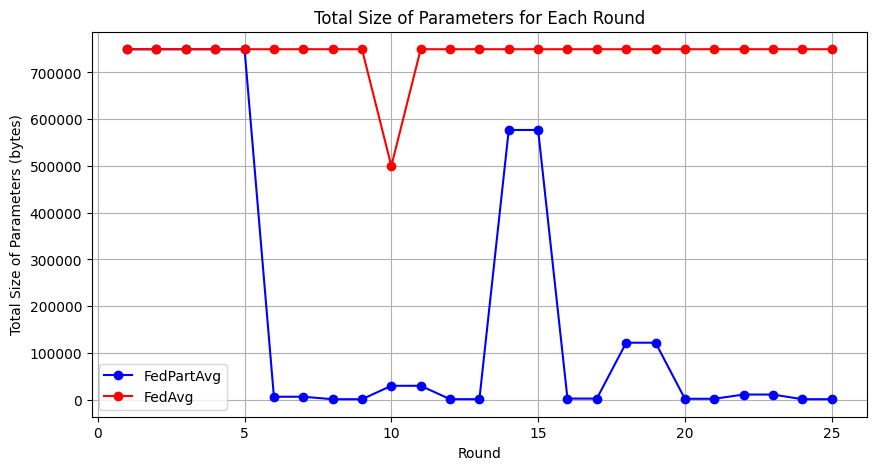

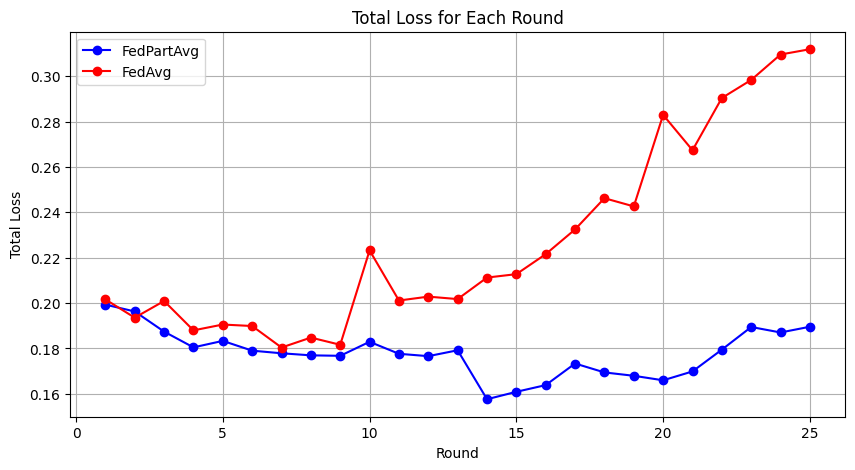

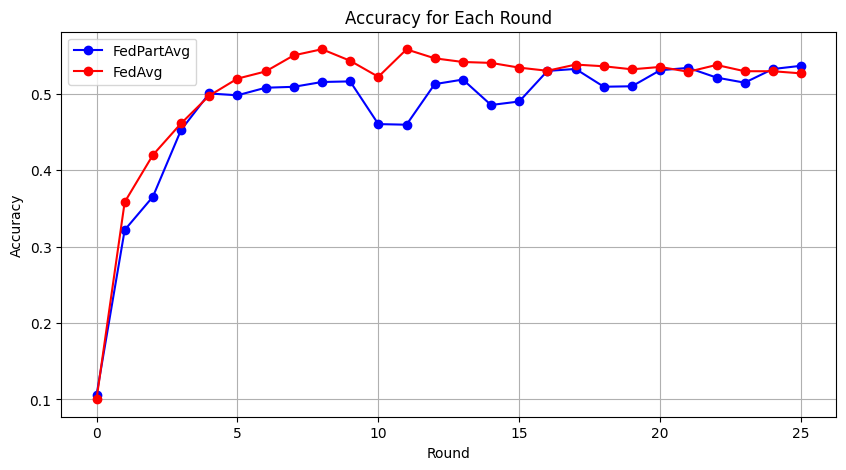

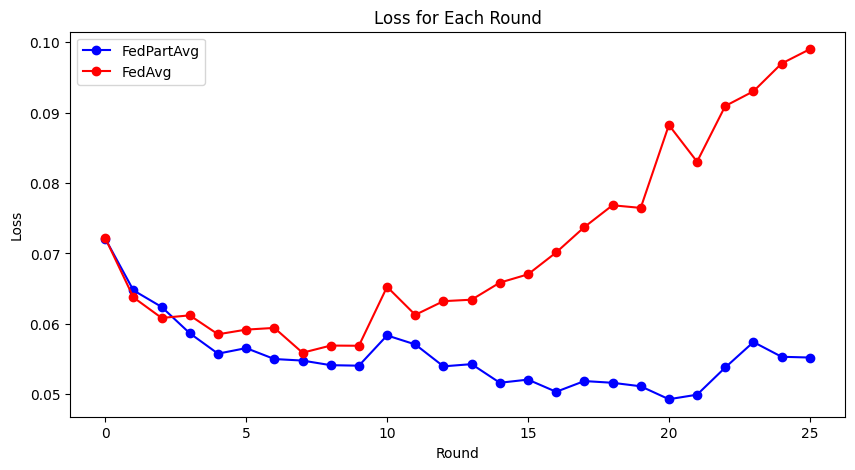

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Plot the total size of parameters for each round
fed_part_avg_rounds = list(fed_part_avg_result.keys())
fed_part_avg_sizes = [fed_part_avg_result[round]["total_size"] for round in fed_part_avg_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_part_avg_rounds, fed_part_avg_sizes, marker='o', linestyle='-', color='b', label='FedPartAvg')
plt.plot(fed_avg_rounds, fed_avg_sizes, marker='o', linestyle='-', color='r', label='FedAvg')
plt.xlabel('Round')
plt.ylabel('Total Size of Parameters (bytes)')
plt.title('Total Size of Parameters for Each Round')
plt.legend()
plt.grid(True)

fed_part_avg_losses = [fed_part_avg_result[round]["total_loss"] for round in fed_part_avg_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_part_avg_rounds, fed_part_avg_losses, marker='o', linestyle='-', color='b', label='FedPartAvg')
plt.plot(fed_avg_rounds, fed_avg_losses, marker='o', linestyle='-', color='r', label='FedAvg')
plt.xlabel('Round')
plt.ylabel('Total Loss')
plt.title('Total Loss for Each Round')
plt.legend()
plt.grid(True)


fed_part_avg_model_rounds = list(fed_part_avg_model_results.keys())
fed_part_avg_accuracies = [fed_part_avg_model_results[round]["global_metrics"]["accuracy"] for round in fed_part_avg_model_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_part_avg_model_rounds, fed_part_avg_accuracies, marker='o', linestyle='-', color='b', label='FedPartAvg')
plt.plot(fed_avg_model_rounds, fed_avg_accuracies, marker='o', linestyle='-', color='r', label='FedAvg')
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.title('Accuracy for Each Round')
plt.legend()
plt.grid(True)

fed_part_avg_global_losses = [fed_part_avg_model_results[round]["global_loss"] for round in fed_part_avg_model_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_part_avg_model_rounds, fed_part_avg_global_losses, marker='o', linestyle='-', color='b', label='FedPartAvg')
plt.plot(fed_avg_model_rounds, fed_avg_global_losses, marker='o', linestyle='-', color='r', label='FedAvg')
plt.xlabel('Round')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss for Each Round')


# FedProxPart Experiments

In [15]:
class FedProxPartFlowerClient(NumPyClient):
    def __init__(self, partition_id, net, trainloader, valloader):
        self.partition_id = partition_id
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        print(f"[Client {self.partition_id}] get_parameters")
        parameters = get_parameters(self.net)
        if config["trainable_layers"] == -1:
            return parameters
        
        trained_layer = parameters[config["trainable_layers"]]
        return [trained_layer]

    def fit(self, parameters, config):
        print(f"[Client {self.partition_id}] fit, config: {config}")
        set_parameters(self.net, parameters)
        global_params = copy.deepcopy(self.net).parameters()
        freeze_layers(self.net, config["trainable_layers"])
        proxima_train(self.net, self.trainloader, EPOCHS, config["proximal_mu"], global_params)
        return self.get_parameters(config), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        print(f"[Client {self.partition_id}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn(context: Context) -> Client:
    net = Net().to(DEVICE)
    partition_id = context.node_config["partition-id"]
    num_partitions = context.node_config["num-partitions"]
    trainloader, valloader, _ = load_datasets(partition_id, num_partitions)
    return FedProxPartFlowerClient(partition_id, net, trainloader, valloader).to_client()


# Create the ClientApp
client = ClientApp(client_fn=client_fn)

In [16]:
fed_part_prox_result = {}

fed_part_prox_model_results = {}

class FedPartProx(FedPartAvg):

    def __init__(
        self,
        *,
        fraction_fit: float = 1.0,
        fraction_evaluate: float = 1.0,
        min_fit_clients: int = 2,
        min_evaluate_clients: int = 2,
        min_available_clients: int = 2,
        evaluate_fn: Optional[
            Callable[
                [int, NDArrays, dict[str, Scalar]],
                Optional[tuple[float, dict[str, Scalar]]],
            ]
        ] = None,
        on_fit_config_fn: Optional[Callable[[int], dict[str, Scalar]]] = None,
        on_evaluate_config_fn: Optional[Callable[[int], dict[str, Scalar]]] = None,
        accept_failures: bool = True,
        initial_parameters: Optional[Parameters] = None,
        fit_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        evaluate_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        proximal_mu: float,
    ) -> None:
        super().__init__(
            fraction_fit=fraction_fit,
            fraction_evaluate=fraction_evaluate,
            min_fit_clients=min_fit_clients,
            min_evaluate_clients=min_evaluate_clients,
            min_available_clients=min_available_clients,
            evaluate_fn=evaluate_fn,
            on_fit_config_fn=on_fit_config_fn,
            on_evaluate_config_fn=on_evaluate_config_fn,
            accept_failures=accept_failures,
            initial_parameters=initial_parameters,
            fit_metrics_aggregation_fn=fit_metrics_aggregation_fn,
            evaluate_metrics_aggregation_fn=evaluate_metrics_aggregation_fn,
        )
        self.proximal_mu = proximal_mu


    def __repr__(self) -> str:
        return "FedPartAvg"
    

    def configure_fit(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> list[tuple[ClientProxy, FitIns]]:
        """Configure the next round of training.

        Sends the proximal factor mu to the clients
        """
        # Get the standard client/config pairs from the FedAvg super-class
        client_config_pairs = super().configure_fit(
            server_round, parameters, client_manager
        )

        # Return client/config pairs with the proximal factor mu added
        return [
            (
                client,
                FitIns(
                    fit_ins.parameters,
                    {**fit_ins.config, "proximal_mu": self.proximal_mu},
                ),
            )
            for client, fit_ins in client_config_pairs
        ]
    
    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""
        
        total_size = 0
        for client, fit_res in results:
            total_size += get_parameters_size(fit_res.parameters)
        print(f"total size: {total_size}")
        
        if fed_part_prox_result.get(server_round):
            fed_part_prox_result[server_round]["total_size"] = total_size
        else:
            fed_part_prox_result[server_round] = {"total_size": total_size}
        


        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]

        aggregated_weights = aggregate(weights_results)
        # parameters_aggregated = ndarrays_to_parameters(aggregate(weights_results))

        if self.layer_training_sequence[self.training_sequence_index -1] == -1:
            self.latest_parameters = ndarrays_to_parameters(aggregated_weights)
        else:
            current_model = parameters_to_ndarrays(self.latest_parameters)
            current_model[self.layer_training_sequence[self.training_sequence_index -1]] = aggregated_weights[0]
            self.latest_parameters = ndarrays_to_parameters(current_model)

        metrics_aggregated = {}
        return self.latest_parameters, metrics_aggregated
    

    def aggregate_evaluate(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, EvaluateRes]],
        failures: List[Union[Tuple[ClientProxy, EvaluateRes], BaseException]],
    ) -> Tuple[Optional[float], Dict[str, Scalar]]:
        """Aggregate evaluation losses using weighted average."""

        if not results:
            return None, {}
        
        total_loss = 0
        for _, evaluate_res in results:
            total_loss += evaluate_res.loss

        if fed_part_prox_result.get(server_round):
            fed_part_prox_result[server_round]["total_loss"] = total_loss
        else:
            fed_part_prox_result[server_round] = {"total_loss": total_loss}

        loss_aggregated = weighted_loss_avg(
            [
                (evaluate_res.num_examples, evaluate_res.loss)
                for _, evaluate_res in results
            ]
        )
        metrics_aggregated = {}
        return loss_aggregated, metrics_aggregated
    

    def evaluate(
        self, server_round: int, parameters: Parameters
    ) -> Optional[tuple[float, dict[str, Scalar]]]:
        """Evaluate model parameters using an evaluation function."""
        if self.evaluate_fn is None:
            # No evaluation function provided
            return None
        parameters_ndarrays = parameters_to_ndarrays(parameters)
        eval_res = self.evaluate_fn(server_round, parameters_ndarrays, {})
        if eval_res is None:
            return None
        
        if server_round in fed_part_prox_model_results:  
            expand_fed_part_prox_model_results= {**fed_part_prox_model_results[server_round], "global_loss": eval_res[0], "global_metrics": eval_res[1]}
        else:
            expand_fed_part_prox_model_results= {"global_loss": eval_res[0], "global_metrics": eval_res[1]}
        
        fed_part_prox_model_results[server_round] = expand_fed_part_prox_model_results
        
        loss, metrics = eval_res
        return loss, metrics


In [17]:
net = Net().to(DEVICE)

_, _, testloader = load_datasets(0, NUM_PARTITIONS)

evaluate_fn = get_evaluate_fn(testloader, net)


def server_fn(context: Context) -> ServerAppComponents:
    # Configure the server for just 3 rounds of training
    config = ServerConfig(num_rounds=NUM_OF_ROUNDS)
    return ServerAppComponents(
        config=config,
        strategy=FedPartProx(proximal_mu=0.1, evaluate_fn=evaluate_fn),
    )

server = ServerApp(server_fn=server_fn)

# Run simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,
    backend_config=backend_config,
)

/Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]
INFO :      Starting Flower ServerApp, config: num_rounds=25, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      initial parameters (loss, other metrics): 0.07213000972270965, {'accuracy': 0.0999}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]


(ClientAppActor pid=44490) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=44490)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=44491) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': -1}
(ClientAppActor pid=44490) Epoch 1: train loss 0.022976040840148926, accuracy 0.7675149700598802
(ClientAppActor pid=44490) [Client 1] get_parameters
(ClientAppActor pid=44489) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': -1} [repeated 2x across cluster]
(ClientAppActor pid=44491) Epoch 1: train loss 0.04644583910703659, accuracy 0.4357546997627304 [repeated 3x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 749760
(ClientAppActor pid=44491) [Client 0] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=44491) Epoch 2: train loss 0.03793221339583397, accuracy 0.5499634969885016 [repeated 2x across cluster]


INFO :      fit progress: (1, 0.06606079496145248, {'accuracy': 0.3054}, 24.727950417029206)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=44489) [Client 1] evaluate, config: {}


(ClientAppActor pid=44489) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 3x across cluster]
(ClientAppActor pid=44489)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 3x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=44490) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': -1}
(ClientAppActor pid=44490) Epoch 1: train loss 0.01814100332558155, accuracy 0.8255988023952096
(ClientAppActor pid=44490) [Client 2] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=44490) [Client 1] get_parameters
(ClientAppActor pid=44491) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': -1} [repeated 2x across cluster]
(ClientAppActor pid=44491) Epoch 1: train loss 0.03670506179332733, accuracy 0.5710896148932287 [repeated 3x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=44491) [Client 0] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=44491) Epoch 2: train loss 0.032111383974552155, accuracy 0.6312283263369228 [repeated 2x across cluster]
total size: 749760


INFO :      fit progress: (2, 0.061009465646743775, {'accuracy': 0.4368}, 47.658505583996885)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=44490) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=44490)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=44490) [Client 2] evaluate, config: {}


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=44491, ip=127.0.0.1, actor_id=fe9dda54889666001cf4787a01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x106c62ab0>)
  File "/Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/requests/models.py", line 1024, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 504 Server Error: Gateway Time-out for url: https://huggingface.co/api/datasets/cifar10/paths-info/0b2714987fa478483af9968de7c934580d0bb9a2

The above exception was the direct cause of the following exception:

ray::ClientAppActor.run() (pid=44491, ip=127.0.0.1, actor_id=fe9dda54889666001cf4787a01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x106c62ab0>)
  File "/Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/flwr/simulation/ray_transport/ray_act

(ClientAppActor pid=44489) [Client 1] evaluate, config: {}


(ClientAppActor pid=44489) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=44489)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
INFO :      aggregate_evaluate: received 2 results and 1 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]


(ClientAppActor pid=44490) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=44490)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=44490) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': -1}
(ClientAppActor pid=44491) Epoch 1: train loss 0.015523763373494148, accuracy 0.8473053892215568
(ClientAppActor pid=44491) [Client 1] get_parameters
(ClientAppActor pid=44491) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': -1} [repeated 2x across cluster]
(ClientAppActor pid=44489) Epoch 1: train loss 0.031217020004987717, accuracy 0.6459207884650484 [repeated 3x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=44489) [Client 0] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=44489) Epoch 2: train loss 0.028331251814961433, accuracy 0.6821500273772586 [repeated 2x across cluster]
total size: 749760


INFO :      fit progress: (3, 0.059658760410547254, {'accuracy': 0.4688}, 89.29743762500584)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=44491) [Client 2] evaluate, config: {}


(ClientAppActor pid=44491) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 3x across cluster]
(ClientAppActor pid=44491)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 3x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=44490) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': -1}
(ClientAppActor pid=44491) Epoch 1: train loss 0.01423743274062872, accuracy 0.8558383233532935
(ClientAppActor pid=44489) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=44491) [Client 1] get_parameters
(ClientAppActor pid=44491) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': -1} [repeated 2x across cluster]
(ClientAppActor pid=44489) Epoch 1: train loss 0.028192859143018723, accuracy 0.6789103851067713 [repeated 3x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 749760
(ClientAppActor pid=44489) [Client 0] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=44489) Epoch 2: train loss 0.025852184742689133, accuracy 0.7092535134148568 [repeated 2x across cluster]


INFO :      fit progress: (4, 0.05825155838727951, {'accuracy': 0.52}, 111.69404841703363)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=44490) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=44490)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=44491) [Client 2] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=44491) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': -1}
(ClientAppActor pid=44491) Epoch 1: train loss 0.013462723232805729, accuracy 0.8661676646706586
(ClientAppActor pid=44489) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=44491) [Client 1] get_parameters
(ClientAppActor pid=44489) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': -1} [repeated 2x across cluster]
(ClientAppActor pid=44489) Epoch 1: train loss 0.025863466784358025, accuracy 0.7070633327249498 [repeated 3x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=44489) [Client 0] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=44489) Epoch 2: train loss 0.023894650861620903, accuracy 0.7284632232159153 [repeated 2x across cluster]
total size: 749760


INFO :      fit progress: (5, 0.05899165483117103, {'accuracy': 0.5255}, 134.5666101250099)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=44490) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=44490)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=44490) [Client 1] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=44490) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 0}
(ClientAppActor pid=44491) Epoch 1: train loss 0.0431189090013504, accuracy 0.48413173652694613
(ClientAppActor pid=44491) [Client 2] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=44491) [Client 1] get_parameters
(ClientAppActor pid=44489) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 0} [repeated 2x across cluster]
(ClientAppActor pid=44489) Epoch 1: train loss 0.02740054950118065, accuracy 0.6878992516882643 [repeated 3x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=44489) [Client 0] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=44489) Epoch 2: train loss 0.026911459863185883, accuracy 0.6921427267749589 [repeated 2x across cluster]
total size: 6453


INFO :      fit progress: (6, 0.05562658188343048, {'accuracy': 0.5392}, 155.95290162501624)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=44490) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=44490)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=44490) [Client 1] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=44490) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 0}
(ClientAppActor pid=44491) Epoch 1: train loss 0.04283317178487778, accuracy 0.49491017964071854
(ClientAppActor pid=44491) [Client 2] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=44491) [Client 1] get_parameters
(ClientAppActor pid=44489) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 0} [repeated 2x across cluster]
(ClientAppActor pid=44490) Epoch 2: train loss 0.0841856375336647, accuracy 0.45536653805682215 [repeated 4x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=44489) [Client 0] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=44489) Epoch 2: train loss 0.02689608745276928, accuracy 0.6942872787004928
total size: 6453


INFO :      fit progress: (7, 0.05571228433251381, {'accuracy': 0.5432}, 176.97780341701582)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=44491) [Client 2] evaluate, config: {}


(ClientAppActor pid=44491) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=44491)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=44490) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 1}
(ClientAppActor pid=44490) [Client 1] evaluate, config: {} [repeated 2x across cluster]


(ClientAppActor pid=44491) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=44491)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]


(ClientAppActor pid=44489) Epoch 1: train loss 0.046775832772254944, accuracy 0.42694610778443115
(ClientAppActor pid=44489) Epoch 2: train loss 0.042346976697444916, accuracy 0.48547904191616764
(ClientAppActor pid=44489) [Client 1] get_parameters
(ClientAppActor pid=44491) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 1} [repeated 2x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=44490) Epoch 2: train loss 0.027586016803979874, accuracy 0.6952911115167001 [repeated 4x across cluster]
(ClientAppActor pid=44490) [Client 0] get_parameters [repeated 2x across cluster]
total size: 1125


INFO :      fit progress: (8, 0.05509018416404724, {'accuracy': 0.5437}, 196.30494266701862)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=44490) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=44490)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=44491) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=44491)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=44491) [Client 1] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=44490) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 1}
(ClientAppActor pid=44489) Epoch 1: train loss 0.047347020357847214, accuracy 0.4251497005988024
(ClientAppActor pid=44489) [Client 2] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=44489) [Client 1] get_parameters
(ClientAppActor pid=44491) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 1} [repeated 2x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=44490) Epoch 2: train loss 0.02758106216788292, accuracy 0.6957930279248038 [repeated 5x across cluster]
(ClientAppActor pid=44490) [Client 0] get_parameters [repeated 2x across cluster]
total size: 1125


INFO :      fit progress: (9, 0.05509458493590355, {'accuracy': 0.5431}, 214.13424887502333)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=44489) [Client 2] evaluate, config: {}


(ClientAppActor pid=44489) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=44489)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]
ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=44490, ip=127.0.0.1, actor_id=b6f64113d0c5a1c0826bfee401000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x109f33380>)
  File "/Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/requests/models.py", line 1024, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 504 Server Error: Gateway Time-out for url: https://huggingface.co/api/datasets/uoft-cs/cifar10/paths-info/0b2714987fa478483af9968de7c934580d0bb9a2

The above exception

(ClientAppActor pid=44491) [Client 1] evaluate, config: {}


(ClientAppActor pid=44491) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=44491)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
INFO :      aggregate_evaluate: received 2 results and 1 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=44491) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 2}


(ClientAppActor pid=44491) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=44491)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=44491) Epoch 1: train loss 0.024854639545083046, accuracy 0.716964774593904


(ClientAppActor pid=44489) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=44489) Found the latest cached dataset configuration 'plain_text' at /Users/macbook/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Sun Feb 23 20:40:10 2025).


(ClientAppActor pid=44489) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 2}


(ClientAppActor pid=44489) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=44489)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=44490) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 2}
(ClientAppActor pid=44491) Epoch 2: train loss 0.023989981040358543, accuracy 0.7278244205146924
(ClientAppActor pid=44491) [Client 0] get_parameters
(ClientAppActor pid=44490) Epoch 1: train loss 0.019091080874204636, accuracy 0.8223053892215569
(ClientAppActor pid=44489) Epoch 1: train loss 0.06723278015851974, accuracy 0.5226236408277797


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 29853


INFO :      fit progress: (10, 0.05759832978248596, {'accuracy': 0.527}, 245.0766110420227)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=44490) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 2x across cluster]
(ClientAppActor pid=44490)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 2x across cluster]


(ClientAppActor pid=44491) [Client 2] evaluate, config: {}
(ClientAppActor pid=44489) [Client 2] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=44489) Epoch 2: train loss 0.05894547328352928, accuracy 0.5434058225184146 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=44490) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 2}
(ClientAppActor pid=44489) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=44490) Epoch 1: train loss 0.06505965441465378, accuracy 0.5308663626797615 [repeated 2x across cluster]
(ClientAppActor pid=44491) [Client 1] get_parameters
(ClientAppActor pid=44489) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 2} [repeated 2x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 29853
(ClientAppActor pid=44489) Epoch 2: train loss 0.02370176464319229, accuracy 0.7333455010038328 [repeated 4x across cluster]
(ClientAppActor pid=44489) [Client 0] get_parameters [repeated 2x across cluster]


INFO :      fit progress: (11, 0.05727805581092835, {'accuracy': 0.5356}, 262.61963354202453)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=44489) [Client 0] evaluate, config: {}


(ClientAppActor pid=44489) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=44489)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=44491) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 3}
(ClientAppActor pid=44491) Epoch 1: train loss 0.035814762115478516, accuracy 0.6119760479041916
(ClientAppActor pid=44490) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=44491) [Client 1] get_parameters
(ClientAppActor pid=44489) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 3} [repeated 2x across cluster]
(ClientAppActor pid=44489) Epoch 1: train loss 0.02696181833744049, accuracy 0.7091622558861106 [repeated 3x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=44489) [Client 0] get_parameters [repeated 2x across cluster]
total size: 1245


INFO :      fit progress: (12, 0.05496293819546699, {'accuracy': 0.5494}, 281.42396316700615)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=44489) [Client 0] evaluate, config: {}
(ClientAppActor pid=44489) Epoch 2: train loss 0.024707606062293053, accuracy 0.731976638072641 [repeated 2x across cluster]


(ClientAppActor pid=44489) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=44489)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=44489) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 3}
(ClientAppActor pid=44490) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=44491) Epoch 1: train loss 0.04167970269918442, accuracy 0.5130239520958084
(ClientAppActor pid=44490) Epoch 1: train loss 0.08972308784723282, accuracy 0.459838653104174
(ClientAppActor pid=44491) [Client 1] get_parameters
(ClientAppActor pid=44491) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 3} [repeated 2x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=44489) Epoch 2: train loss 0.02452777326107025, accuracy 0.7331629859463406 [repeated 4x across cluster]
(ClientAppActor pid=44489) [Client 0] get_parameters [repeated 2x across cluster]
total size: 1245


INFO :      fit progress: (13, 0.05517336555123329, {'accuracy': 0.5468}, 298.4494288749993)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=44491) [Client 2] evaluate, config: {}


(ClientAppActor pid=44491) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=44491)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=44490) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 4}
(ClientAppActor pid=44490) Epoch 1: train loss 0.014066886156797409, accuracy 0.8615269461077845
(ClientAppActor pid=44490) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=44490) [Client 1] get_parameters
(ClientAppActor pid=44489) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 4} [repeated 2x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=44489) Epoch 2: train loss 0.021745597943663597, accuracy 0.7539697025004563 [repeated 5x across cluster]
(ClientAppActor pid=44489) [Client 0] get_parameters [repeated 2x across cluster]
total size: 577053


INFO :      fit progress: (14, 0.05201362481713295, {'accuracy': 0.5413}, 315.6352802090114)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=44490) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=44490)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=44491) [Client 1] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=44490) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 4}
(ClientAppActor pid=44490) Epoch 1: train loss 0.013299817219376564, accuracy 0.8681137724550898
(ClientAppActor pid=44489) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=44490) [Client 1] get_parameters
(ClientAppActor pid=44489) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 4} [repeated 2x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=44489) Epoch 2: train loss 0.02080911211669445, accuracy 0.7667457565249133 [repeated 5x across cluster]
(ClientAppActor pid=44489) [Client 0] get_parameters [repeated 2x across cluster]
total size: 577053


INFO :      fit progress: (15, 0.050856192892789844, {'accuracy': 0.5305}, 332.6546845000121)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=44490) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=44490)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=44491) [Client 1] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=44491) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 5}
(ClientAppActor pid=44490) Epoch 1: train loss 0.04784148558974266, accuracy 0.4245508982035928
(ClientAppActor pid=44489) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=44490) [Client 1] get_parameters
(ClientAppActor pid=44489) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 5} [repeated 2x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 2493
(ClientAppActor pid=44489) Epoch 2: train loss 0.02160765789449215, accuracy 0.7602664719839387 [repeated 5x across cluster]
(ClientAppActor pid=44489) [Client 0] get_parameters [repeated 2x across cluster]


INFO :      fit progress: (16, 0.0514624282002449, {'accuracy': 0.5546}, 348.9214440420037)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=44491) [Client 1] evaluate, config: {}


(ClientAppActor pid=44491) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=44491)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=44491) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 5}
(ClientAppActor pid=44491) Epoch 1: train loss 0.07288239896297455, accuracy 0.4970185899684321
(ClientAppActor pid=44490) [Client 2] evaluate, config: {} [repeated 2x across cluster]


(ClientAppActor pid=44490) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=44490)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]


(ClientAppActor pid=44491) [Client 2] get_parameters
(ClientAppActor pid=44490) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 5} [repeated 2x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=44489) Epoch 2: train loss 0.02136734127998352, accuracy 0.7632779704325607 [repeated 5x across cluster]
total size: 2493


INFO :      fit progress: (17, 0.052743311178684235, {'accuracy': 0.5564}, 364.8107337920228)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=44489) [Client 0] evaluate, config: {}
(ClientAppActor pid=44489) [Client 0] get_parameters [repeated 2x across cluster]


(ClientAppActor pid=44489) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=44489)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=44491) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=44491)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=44491) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 6}
(ClientAppActor pid=44491) Epoch 1: train loss 0.013988126069307327, accuracy 0.8589820359281437
(ClientAppActor pid=44490) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=44491) [Client 1] get_parameters


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=44489) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 6} [repeated 2x across cluster]
(ClientAppActor pid=44489) Epoch 2: train loss 0.019982637837529182, accuracy 0.776282168278883 [repeated 5x across cluster]
(ClientAppActor pid=44489) [Client 0] get_parameters [repeated 2x across cluster]
total size: 122013


INFO :      fit progress: (18, 0.053365422123670576, {'accuracy': 0.5486}, 380.8090947919991)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=44489) [Client 0] evaluate, config: {}


(ClientAppActor pid=44489) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=44489)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=44489) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 6}
(ClientAppActor pid=44490) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 6}
(ClientAppActor pid=44490) Epoch 1: train loss 0.013370620086789131, accuracy 0.8670658682634731
(ClientAppActor pid=44490) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=44490) [Client 1] get_parameters


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 122013
(ClientAppActor pid=44491) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 6}
(ClientAppActor pid=44491) Epoch 2: train loss 0.01974918507039547, accuracy 0.7776510312100748 [repeated 5x across cluster]
(ClientAppActor pid=44491) [Client 0] get_parameters [repeated 2x across cluster]


INFO :      fit progress: (19, 0.054260535806417466, {'accuracy': 0.5328}, 397.3546116250218)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=44490) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=44490)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=44490) [Client 2] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=44489) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 7}
(ClientAppActor pid=44489) Epoch 1: train loss 0.04173097014427185, accuracy 0.5140718562874251
(ClientAppActor pid=44491) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=44489) [Client 1] get_parameters
(ClientAppActor pid=44490) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 7} [repeated 2x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=44491) Epoch 2: train loss 0.02089446224272251, accuracy 0.7674301879905092 [repeated 5x across cluster]
(ClientAppActor pid=44491) [Client 0] get_parameters [repeated 2x across cluster]
total size: 2061


INFO :      fit progress: (20, 0.04963405497670174, {'accuracy': 0.5636}, 415.2522825000342)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=44490) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=44490)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=44490) [Client 1] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=44489) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 7}
(ClientAppActor pid=44489) Epoch 1: train loss 0.04234323278069496, accuracy 0.5116766467065869
(ClientAppActor pid=44489) [Client 2] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=44489) [Client 1] get_parameters


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 2061
(ClientAppActor pid=44490) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 7} [repeated 2x across cluster]
(ClientAppActor pid=44491) Epoch 2: train loss 0.02046217769384384, accuracy 0.7734988136521262 [repeated 5x across cluster]
(ClientAppActor pid=44491) [Client 0] get_parameters [repeated 2x across cluster]


INFO :      fit progress: (21, 0.04916259968280792, {'accuracy': 0.5642}, 431.13677445903886)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=44491) [Client 0] evaluate, config: {}


(ClientAppActor pid=44491) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=44491)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=44491) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 8}
(ClientAppActor pid=44490) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 8}
(ClientAppActor pid=44489) Epoch 1: train loss 0.0145846176892519, accuracy 0.8502994011976048
(ClientAppActor pid=44490) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=44489) [Client 1] get_parameters


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=44489) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 8}
(ClientAppActor pid=44491) Epoch 2: train loss 0.019705213606357574, accuracy 0.7789286366125205 [repeated 5x across cluster]
(ClientAppActor pid=44491) [Client 0] get_parameters [repeated 2x across cluster]
total size: 11133


INFO :      fit progress: (22, 0.05397045788168907, {'accuracy': 0.5485}, 446.9174434170127)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=44491) [Client 0] evaluate, config: {}


(ClientAppActor pid=44491) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=44491)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=44490) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 8}
(ClientAppActor pid=44490) Epoch 1: train loss 0.014585760422050953, accuracy 0.8483532934131737
(ClientAppActor pid=44490) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=44490) [Client 1] get_parameters


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=44489) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 8} [repeated 2x across cluster]
(ClientAppActor pid=44491) Epoch 2: train loss 0.019631268456578255, accuracy 0.7799324694287278 [repeated 5x across cluster]
(ClientAppActor pid=44491) [Client 0] get_parameters [repeated 2x across cluster]
total size: 11133


INFO :      fit progress: (23, 0.05656430495381355, {'accuracy': 0.5384}, 462.24413758399896)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=44490) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=44490)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=44491) [Client 0] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=44491) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 9}
(ClientAppActor pid=44490) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 9}
(ClientAppActor pid=44490) Epoch 1: train loss 0.05089033767580986, accuracy 0.4173652694610778
(ClientAppActor pid=44490) Epoch 2: train loss 0.04418398067355156, accuracy 0.49491017964071854
(ClientAppActor pid=44490) [Client 1] get_parameters
(ClientAppActor pid=44489) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=44489) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 9}


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 1173
(ClientAppActor pid=44491) Epoch 2: train loss 0.021808821707963943, accuracy 0.7565249133053477 [repeated 4x across cluster]
(ClientAppActor pid=44491) [Client 0] get_parameters [repeated 2x across cluster]


INFO :      fit progress: (24, 0.05465011967420578, {'accuracy': 0.56}, 477.6769483750104)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=44490) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=44490)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=44491) [Client 0] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=44491) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 9}
(ClientAppActor pid=44490) Epoch 1: train loss 0.05108540877699852, accuracy 0.4245508982035928
(ClientAppActor pid=44489) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=44490) [Client 1] get_parameters


INFO :      aggregate_fit: received 3 results and 0 failures


total size: 1173
(ClientAppActor pid=44489) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 9} [repeated 2x across cluster]
(ClientAppActor pid=44491) Epoch 2: train loss 0.020825035870075226, accuracy 0.7677952181054937 [repeated 5x across cluster]
(ClientAppActor pid=44491) [Client 0] get_parameters [repeated 2x across cluster]


INFO :      fit progress: (25, 0.05459137164950371, {'accuracy': 0.5624}, 493.2000763750402)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=44490) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=44490)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=44490) [Client 2] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 25 round(s) in 496.44s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.06664242841045778
INFO :      		round 2: 0.08208458269611758
INFO :      		round 3: 0.05898884811395354
INFO :      		round 4: 0.05756741030943669
INFO :      		round 5: 0.058634418725567954
INFO :      		round 6: 0.055292054498104794
INFO :      		round 7: 0.05531554426605267
INFO :      		round 8: 0.05472977713439378
INFO :      		round 9: 0.082208159497214
INFO :      		round 10: 0.05715836925492539
INFO :      		round 11: 0.05684191287481995
INFO :      		round 12: 0.05454482595084309
INFO :      		round 13: 0.05476467351675836
INFO :      		round 14: 0.05158473101617758
INFO :      		round 15: 0.05057438046386732
INFO :      		round 16: 0.051162543471275086
INFO :      		round 17: 0.05242893964679525
INFO :      		round 18: 0.05294507271832386
INFO :      		round 19: 0

(ClientAppActor pid=44489) [Client 1] evaluate, config: {} [repeated 2x across cluster]


(ClientAppActor pid=44489) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 2x across cluster]
(ClientAppActor pid=44489)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 2x across cluster]


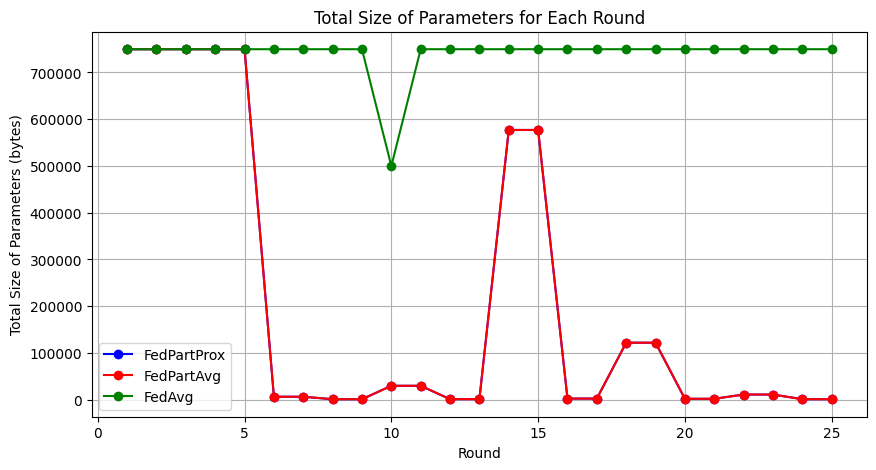

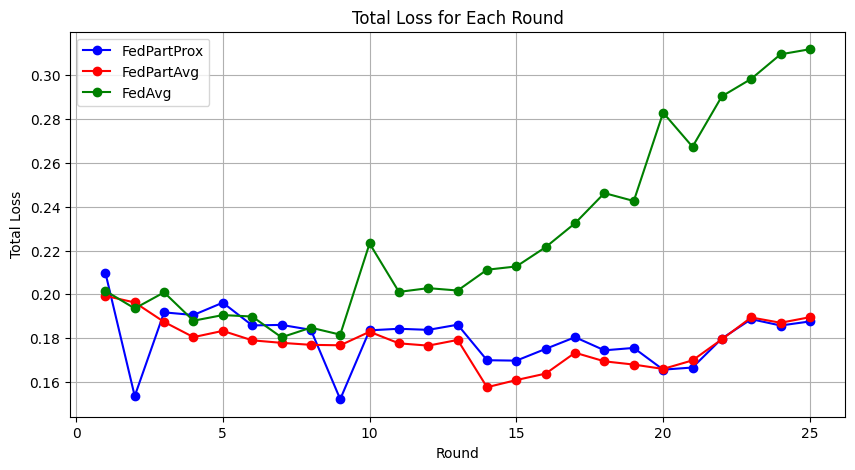

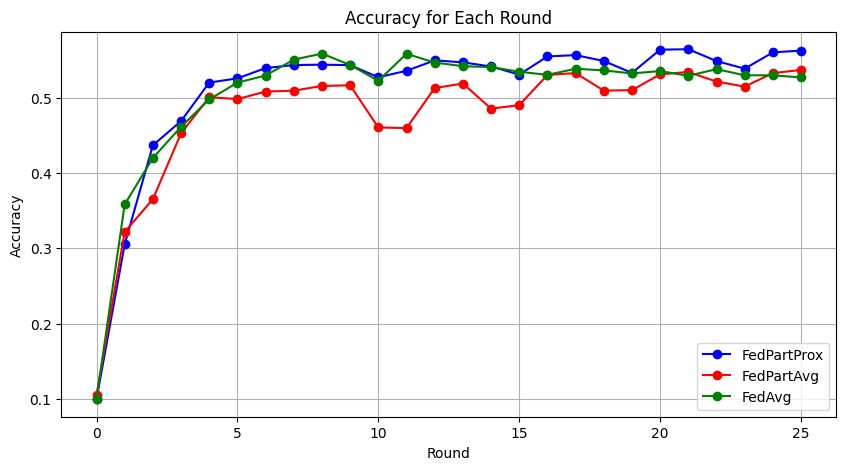

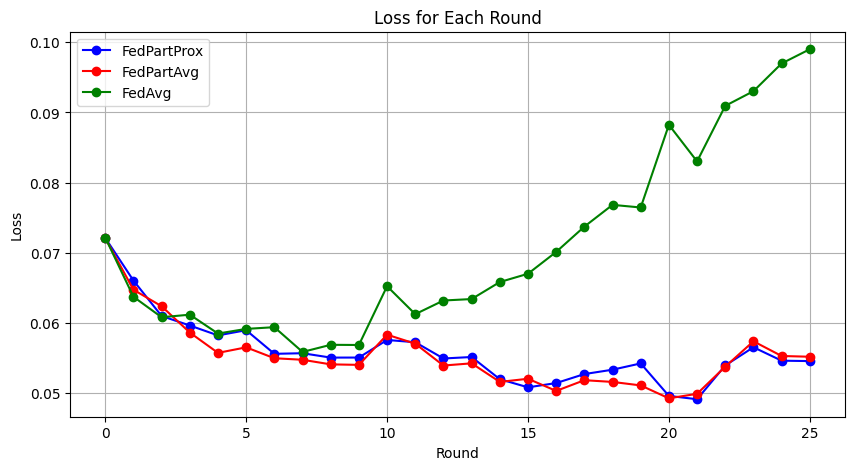

In [18]:
fed_part_prox_rounds = list(fed_part_prox_result.keys())
fed_part_prox_sizes = [fed_part_prox_result[round]["total_size"] for round in fed_part_prox_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_part_prox_rounds, fed_part_prox_sizes, marker='o', linestyle='-', color='b', label='FedPartProx')
plt.plot(fed_part_avg_rounds, fed_part_avg_sizes, marker='o', linestyle='-', color='r', label='FedPartAvg')
plt.plot(fed_avg_rounds, fed_avg_sizes, marker='o', linestyle='-', color='g', label='FedAvg')
plt.xlabel('Round')
plt.ylabel('Total Size of Parameters (bytes)')
plt.title('Total Size of Parameters for Each Round')
plt.legend()
plt.grid(True)

fed_part_prox_losses = [fed_part_prox_result[round]["total_loss"] for round in fed_part_prox_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_part_prox_rounds, fed_part_prox_losses, marker='o', linestyle='-', color='b', label='FedPartProx')
plt.plot(fed_part_avg_rounds, fed_part_avg_losses, marker='o', linestyle='-', color='r', label='FedPartAvg')
plt.plot(fed_avg_rounds, fed_avg_losses, marker='o', linestyle='-', color='g', label='FedAvg')
plt.xlabel('Round')
plt.ylabel('Total Loss')
plt.title('Total Loss for Each Round')
plt.legend()
plt.grid(True)


fed_part_prox_model_rounds = list(fed_part_prox_model_results.keys())
fed_part_prox_accuracies = [fed_part_prox_model_results[round]["global_metrics"]["accuracy"] for round in fed_part_prox_model_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_part_prox_model_rounds, fed_part_prox_accuracies, marker='o', linestyle='-', color='b', label='FedPartProx')
plt.plot(fed_part_avg_model_rounds, fed_part_avg_accuracies, marker='o', linestyle='-', color='r', label='FedPartAvg')
plt.plot(fed_avg_model_rounds, fed_avg_accuracies, marker='o', linestyle='-', color='g', label='FedAvg')
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.title('Accuracy for Each Round')
plt.legend()
plt.grid(True)

fed_part_prox_global_losses = [fed_part_prox_model_results[round]["global_loss"] for round in fed_part_prox_model_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_part_prox_model_rounds, fed_part_prox_global_losses, marker='o', linestyle='-', color='b', label='FedPartProx')
plt.plot(fed_part_avg_model_rounds, fed_part_avg_global_losses, marker='o', linestyle='-', color='r', label='FedPartAvg')   
plt.plot(fed_avg_model_rounds, fed_avg_global_losses, marker='o', linestyle='-', color='g', label='FedAvg')
plt.xlabel('Round')
plt.ylabel('Loss')
plt.title('Loss for Each Round')
plt.legend()
plt.grid(True)




# FedMoon Experiments: